<a href="https://colab.research.google.com/github/mileskarr/Final-Project/blob/main/Copy_of_Draft_Code_for_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Imports
import pandas as pd
import numpy as np
import os
import glob
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import ToktokTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import warnings
import re
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import random
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
from collections import Counter
import collections
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [2]:
os.chdir("/content/drive/MyDrive/CIND820/Data/Reviews")
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
combined_file = pd.concat([pd.read_csv(f) for f in all_filenames])



In [3]:
# We can see here that there is a high volume of missing data
missing = []
unique = []
types = []
variables = []
count = []

for item in combined_file.columns:
    variables.append(item)
    missing.append(combined_file[item].isnull().sum())
    unique.append(combined_file[item].nunique())
    types.append(combined_file[item].dtypes)
    count.append(len(combined_file[item]))

output = pd.DataFrame({
    'variable': variables,
    'dtype': types,
    'count': count,
    'unique': unique,
    'missing': missing,

})
print("Df info : ")
output.sort_values("missing",ascending=False).reset_index(drop=True)


Df info : 


variable    dtype    count  unique  missing
0                helpfulness  float64  1094411    3767   561592
1               review_title   object  1094411  364105   310654
2                 hair_color   object  1094411       7   226768
3                  eye_color   object  1094411       6   209628
4                  skin_tone   object  1094411      14   170539
5             is_recommended  float64  1094411       2   167988
6                  skin_type   object  1094411       4   111557
7                review_text   object  1094411  969419     1444
8                 brand_name   object  1094411     142        0
9               product_name   object  1094411    2334        0
10                product_id   object  1094411    2351        0
11                Unnamed: 0    int64  1094411  602130        0
12                 author_id   object  1094411  578653        0
13           submission_time   object  1094411    5317        0
14  total_pos_feedback_count    int64  1094411     590        0
15  total_neg_feedback_count    int64  1094411     259        0
16      total_feedback_count    int64  1094411     676        0
17                    rating    int64  1094411       5        0
18                 price_usd  float64  1094411     221        0

In [4]:
# To view datatypes.
combined_file.dtypes

Unnamed: 0                    int64
author_id                    object
rating                        int64
is_recommended              float64
helpfulness                 float64
total_feedback_count          int64
total_neg_feedback_count      int64
total_pos_feedback_count      int64
submission_time              object
review_text                  object
review_title                 object
skin_tone                    object
eye_color                    object
skin_type                    object
hair_color                   object
product_id                   object
product_name                 object
brand_name                   object
price_usd                   float64
dtype: object

In [5]:
#Here we can see that the mean review rating given by a user is 4.3 and the median a 4. We should investigate whether the dataset is balanced.
combined_file.describe()

Unnamed: 0        rating  is_recommended    helpfulness  \
count  1.094411e+06  1.094411e+06   926423.000000  532819.000000   
mean   1.989864e+05  4.299158e+00        0.839962       0.767782   
std    1.749886e+05  1.149444e+00        0.366642       0.317164   
min    0.000000e+00  1.000000e+00        0.000000       0.000000   
25%    5.590600e+04  4.000000e+00        1.000000       0.652174   
50%    1.308240e+05  5.000000e+00        1.000000       0.928571   
75%    3.285265e+05  5.000000e+00        1.000000       1.000000   
max    6.021290e+05  5.000000e+00        1.000000       1.000000   

       total_feedback_count  total_neg_feedback_count  \
count          1.094411e+06              1.094411e+06   
mean           4.177126e+00              8.948695e-01   
std            2.271524e+01              5.288943e+00   
min            0.000000e+00              0.000000e+00   
25%            0.000000e+00              0.000000e+00   
50%            0.000000e+00              0.000000e+00   
75%            3.000000e+00              1.000000e+00   
max            5.464000e+03              1.159000e+03   

       total_pos_feedback_count     price_usd  
count              1.094411e+06  1.094411e+06  
mean               3.282257e+00  4.900838e+01  
std                1.967482e+01  4.004338e+01  
min                0.000000e+00  3.000000e+00  
25%                0.000000e+00  2.500000e+01  
50%                0.000000e+00  3.900000e+01  
75%                3.000000e+00  6.200000e+01  
max                5.050000e+03  1.900000e+03

In [6]:
#Here we can see a 5 and 4 star reviews making up the majority of rating indicating the dataset is imbalanced.
print (combined_file['rating'].value_counts())

5    698951
4    199389
3     81816
1     61223
2     53032
Name: rating, dtype: int64


In [7]:
#Changing data type of author_id for compatibility with report generator
combined_file['author_id'] = combined_file['author_id'].astype(str)

In [8]:
pip install vaderSentiment


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.6 MB/s eta 0:00:00


In [9]:
pip install sweetviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 25.2 MB/s eta 0:00:00


In [10]:
import statsmodels.api as sm
import sweetviz as sv


In [11]:
#Generate exploratory data analysis report
report = sv.analyze(combined_file)

                                             |          | [  0%]   00:00 -> (? left)


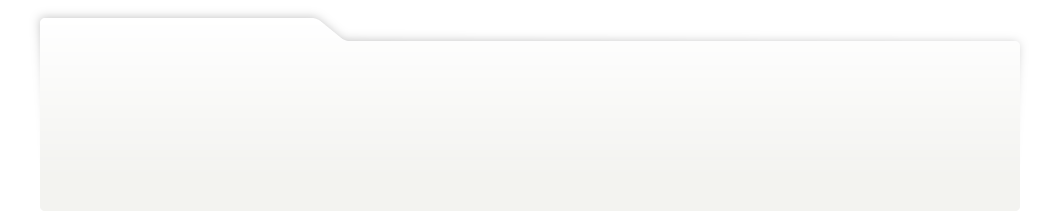
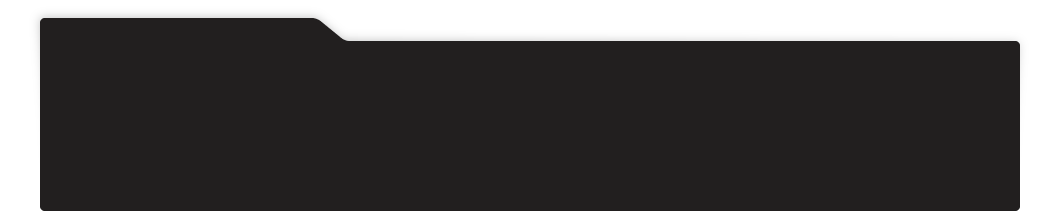
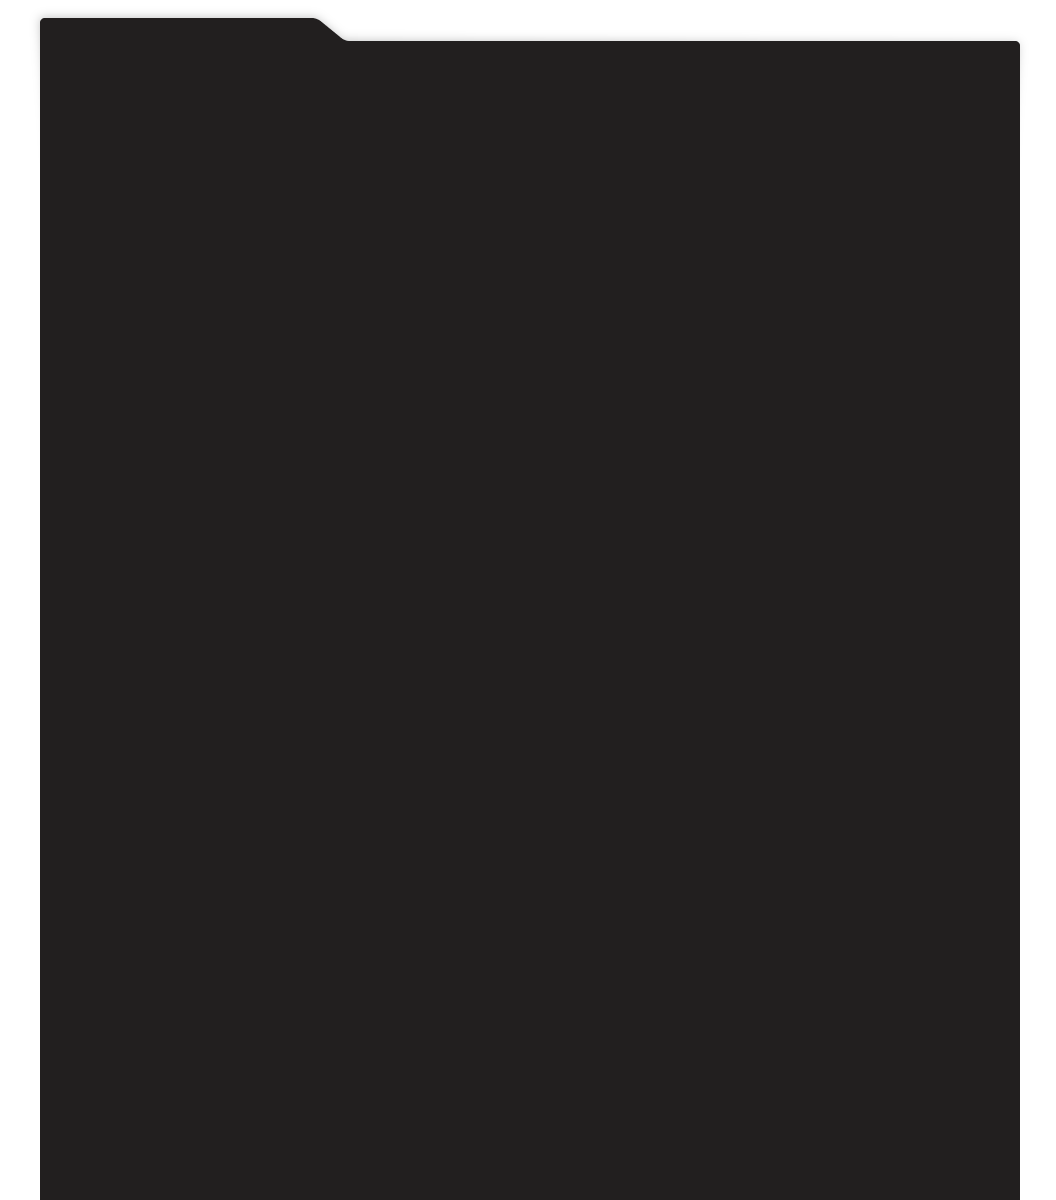
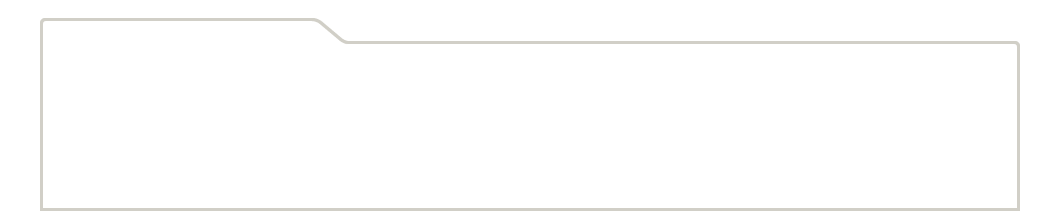
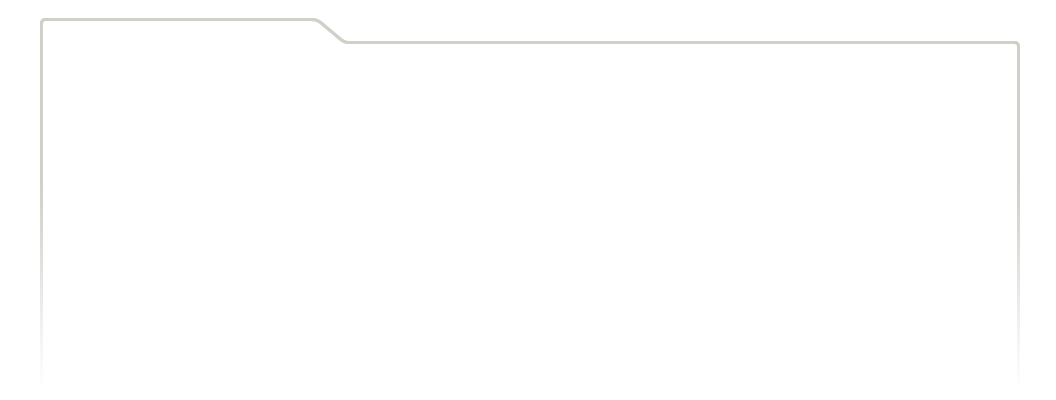
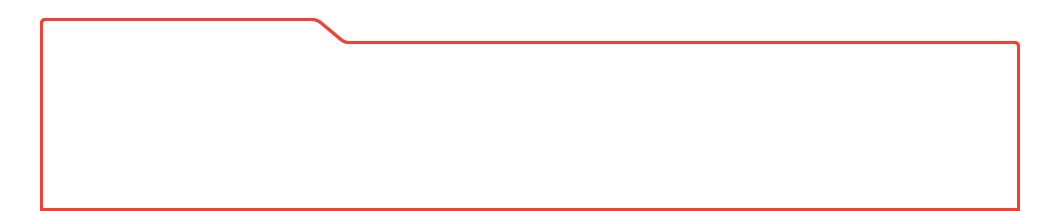
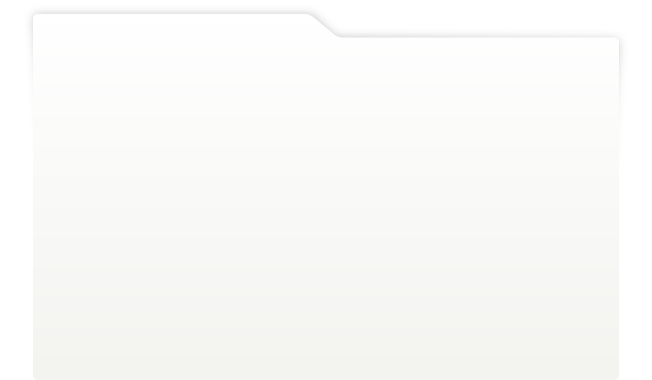
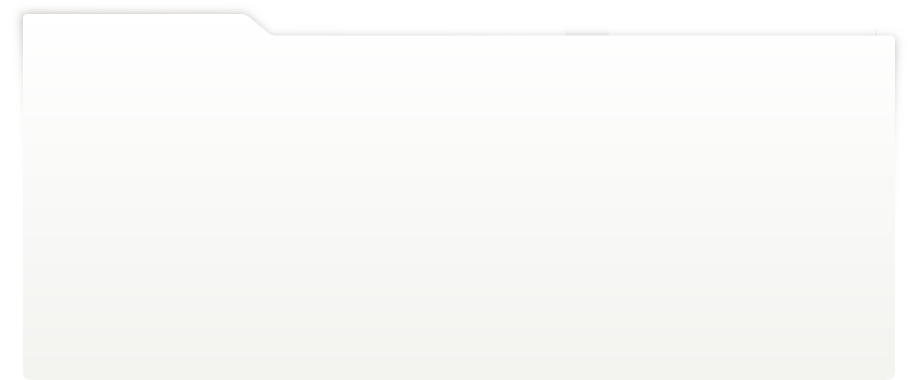
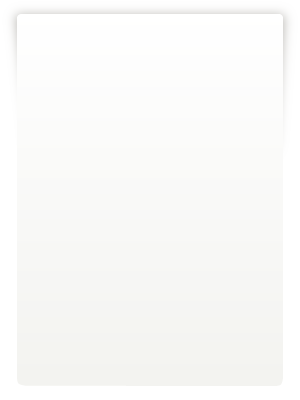
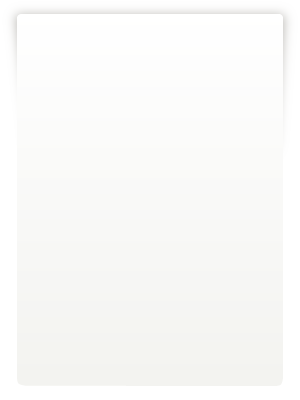
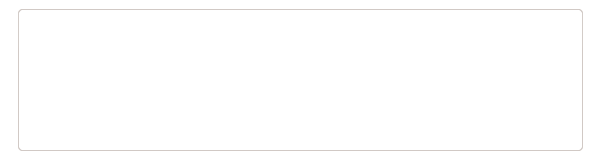
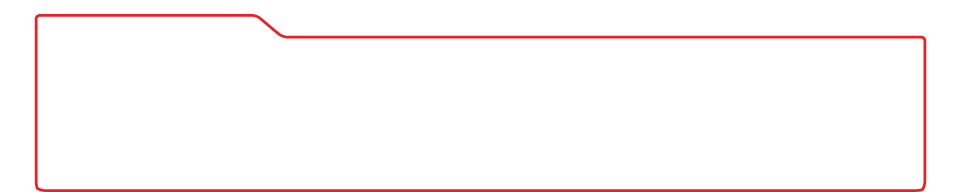
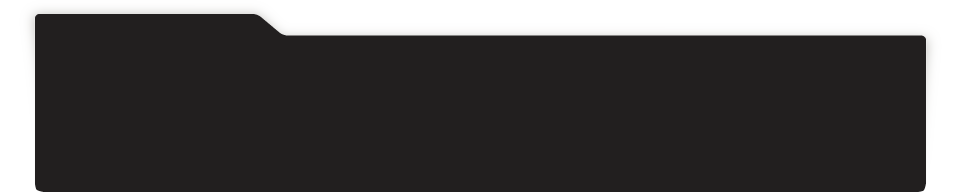
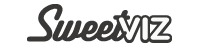
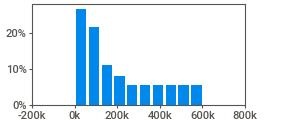
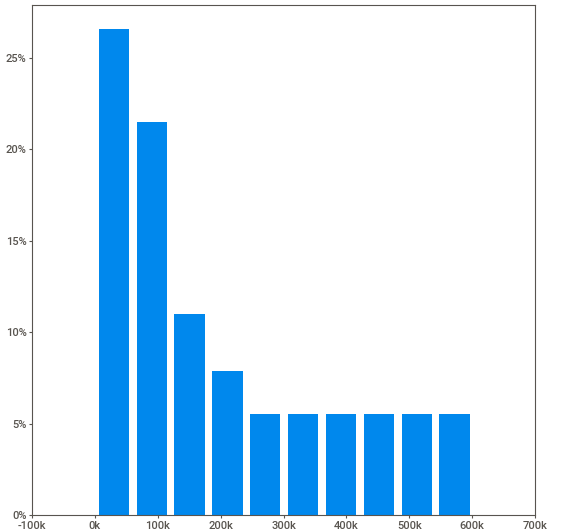
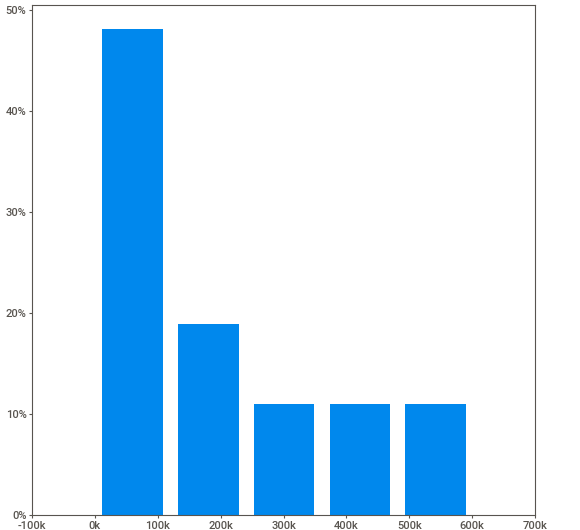
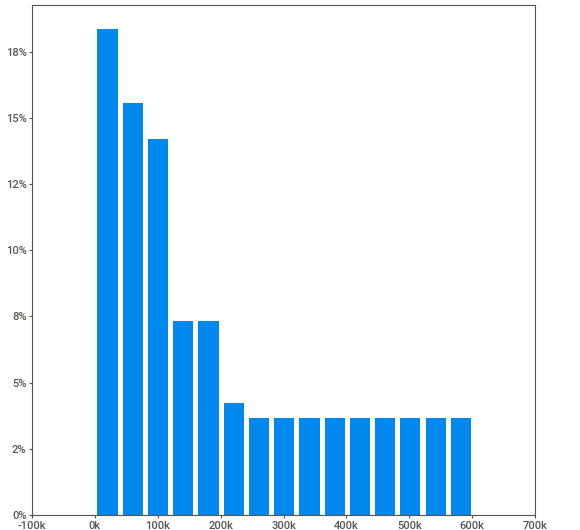
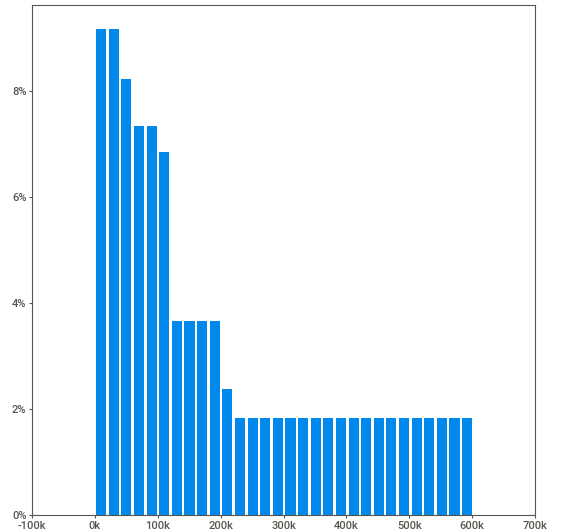
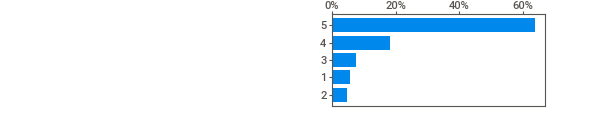
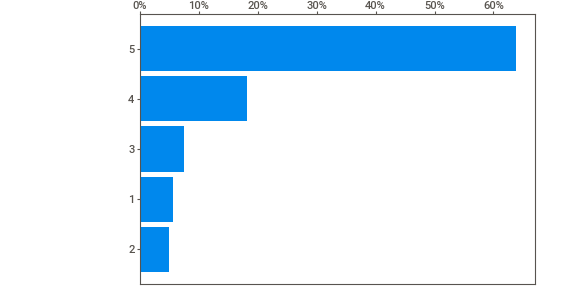
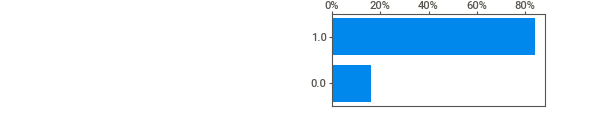
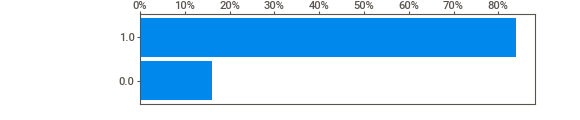
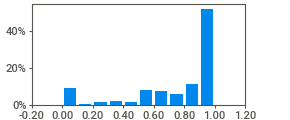
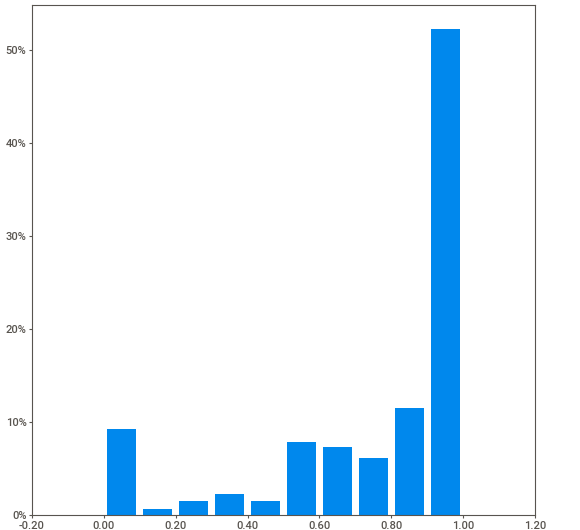
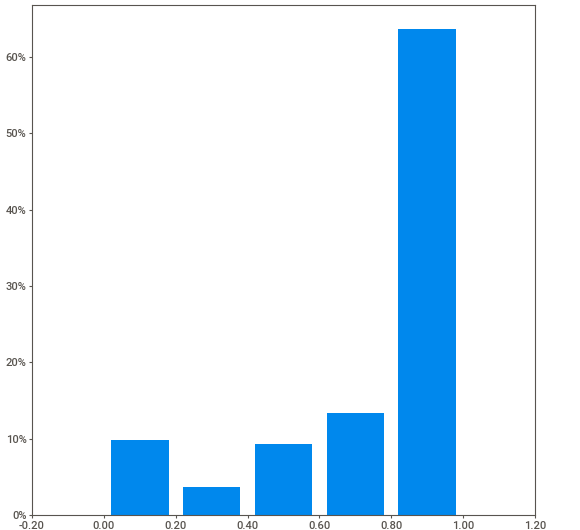
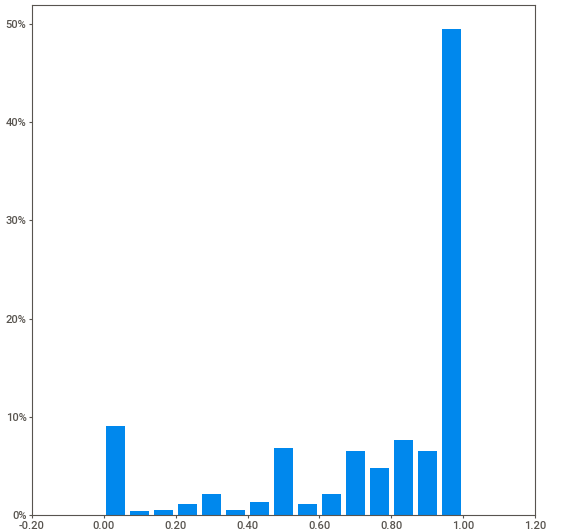
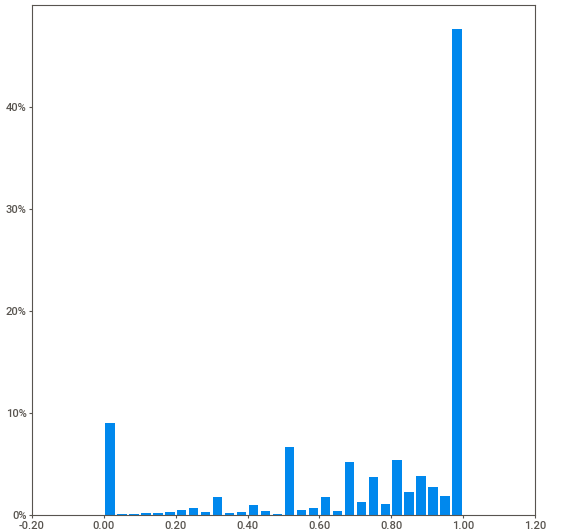
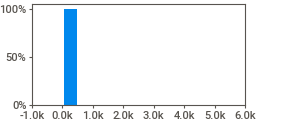
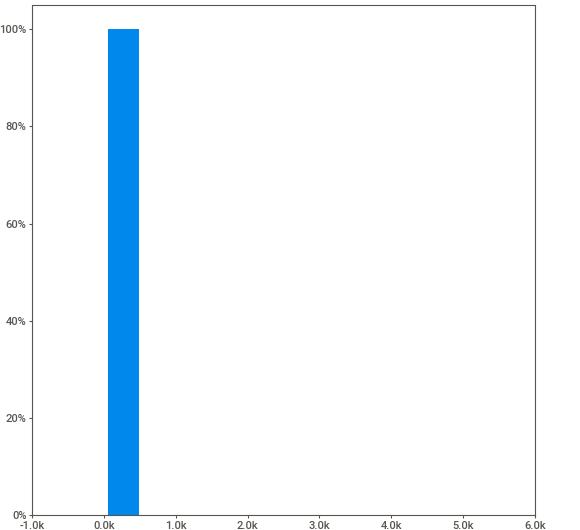
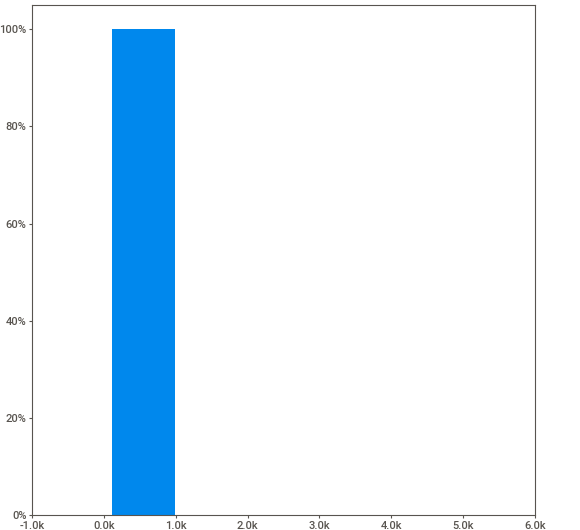
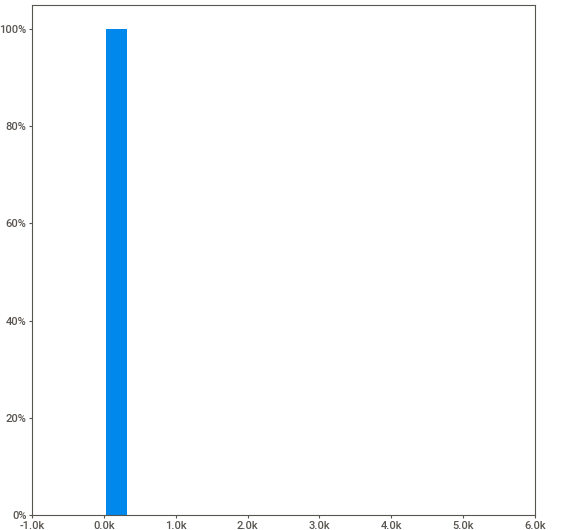
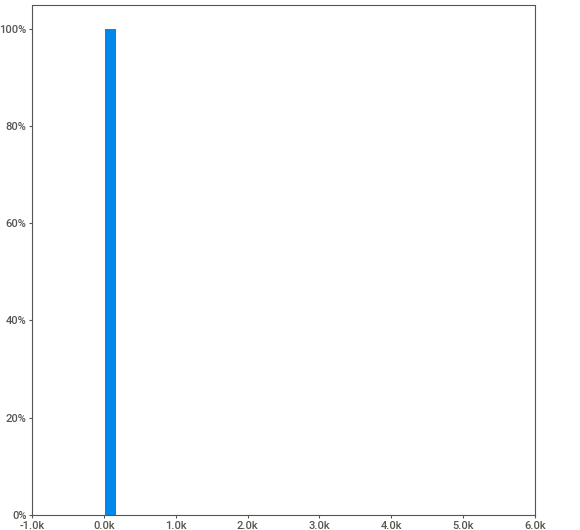
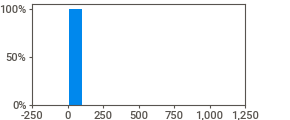
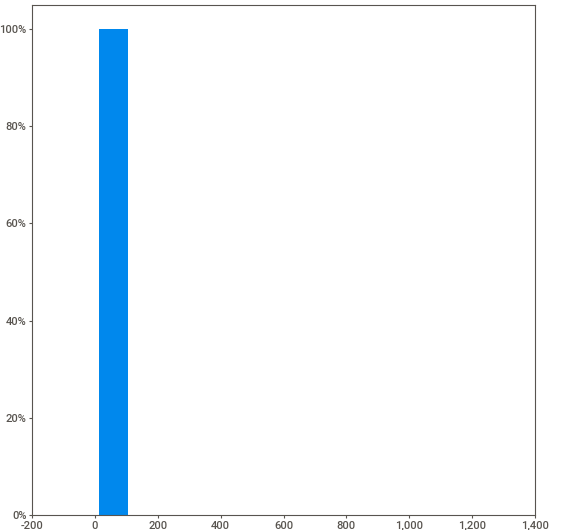
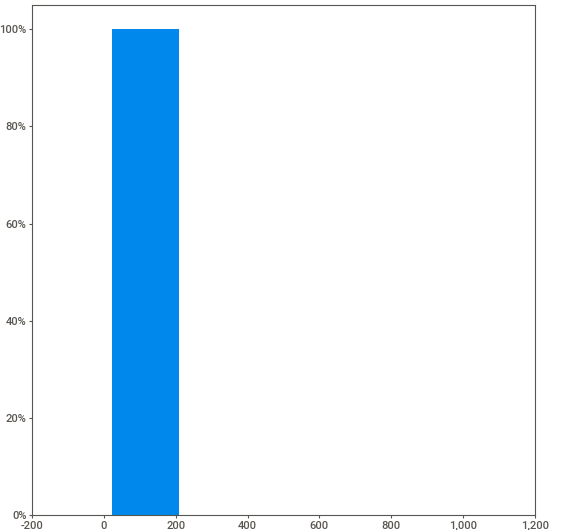
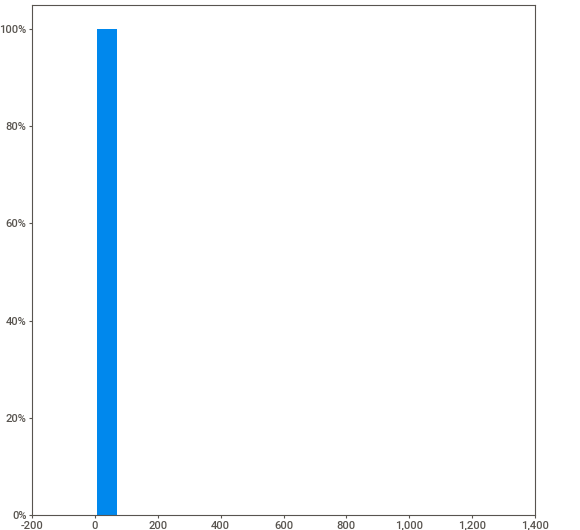
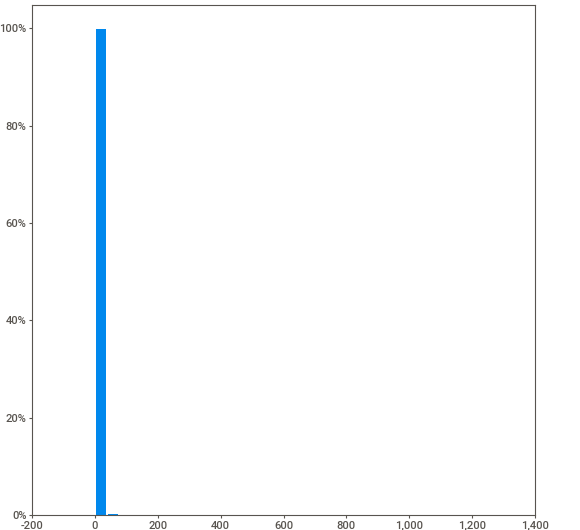
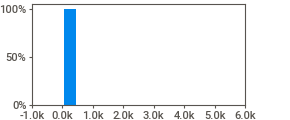
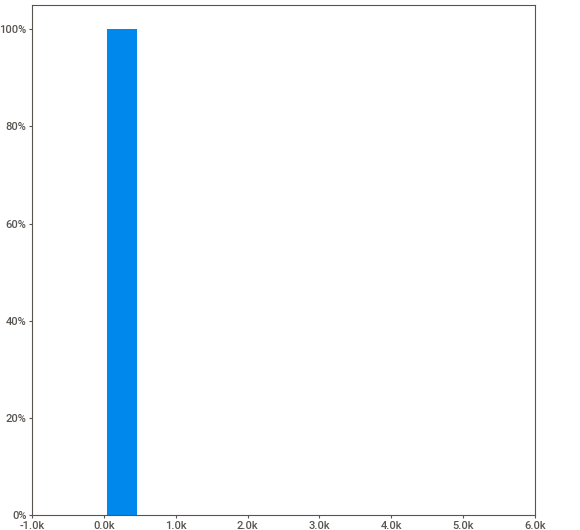
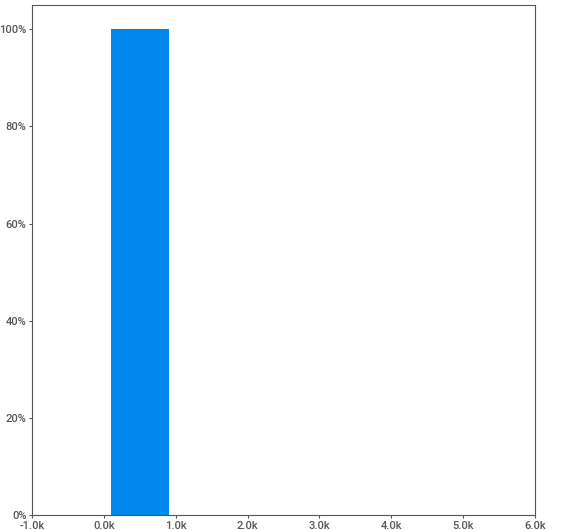
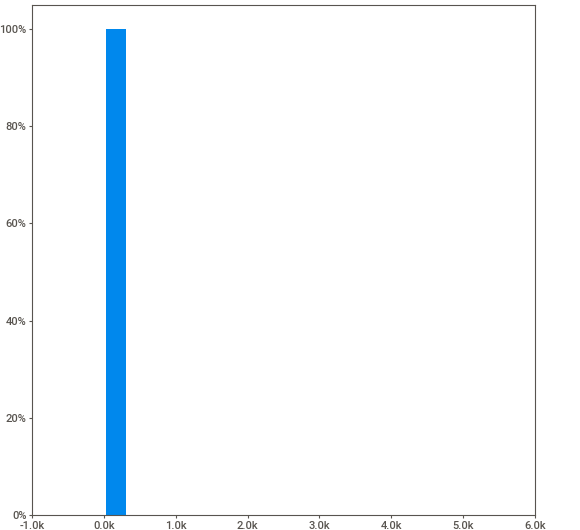
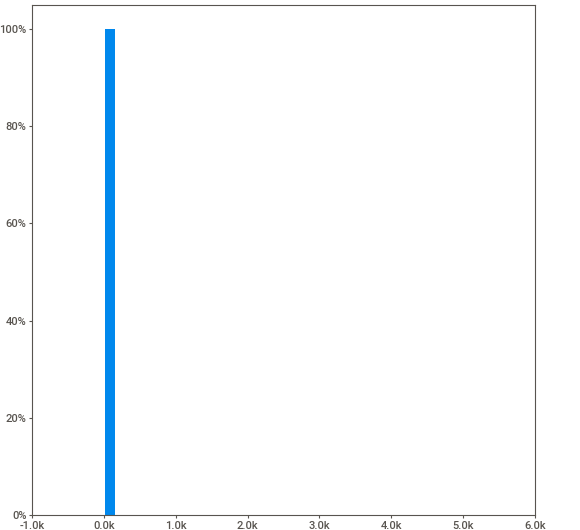
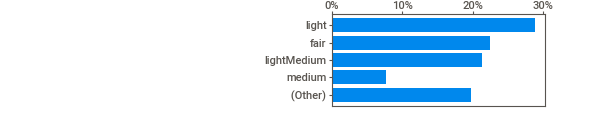
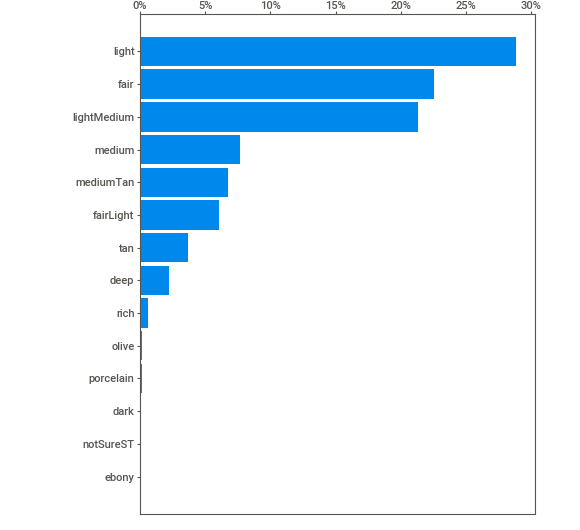
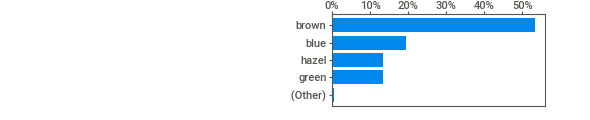
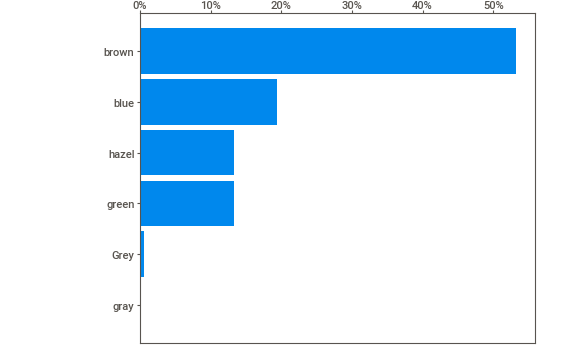
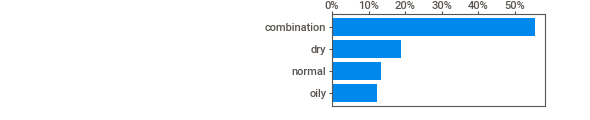
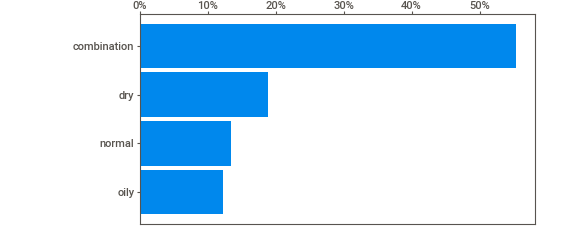
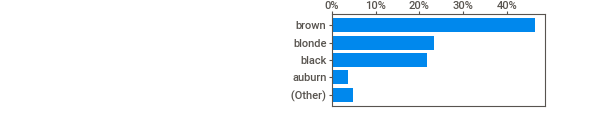
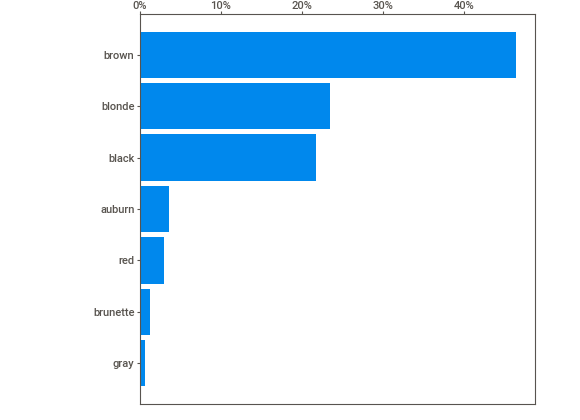
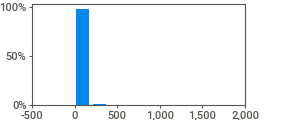
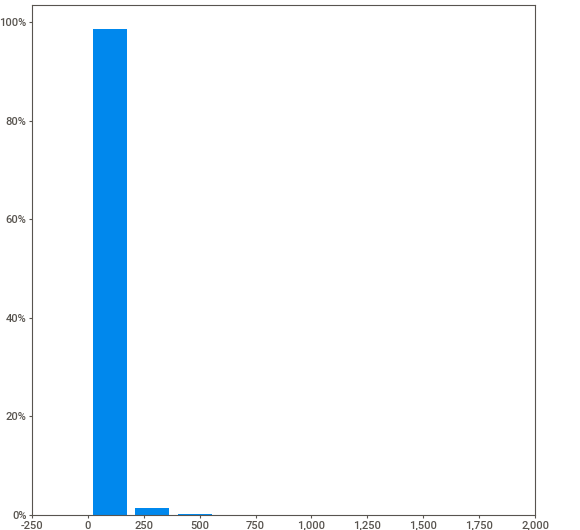
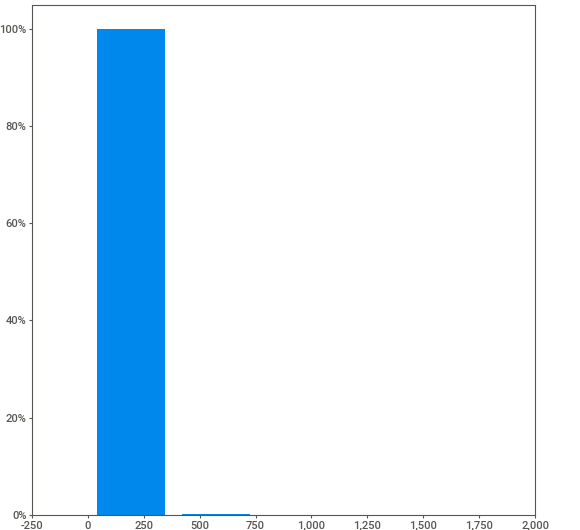
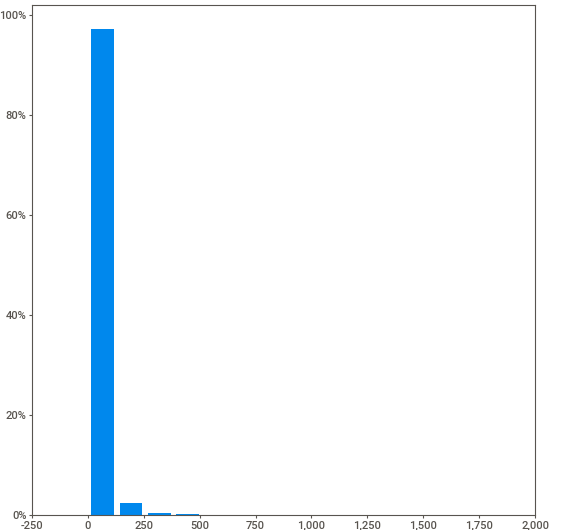
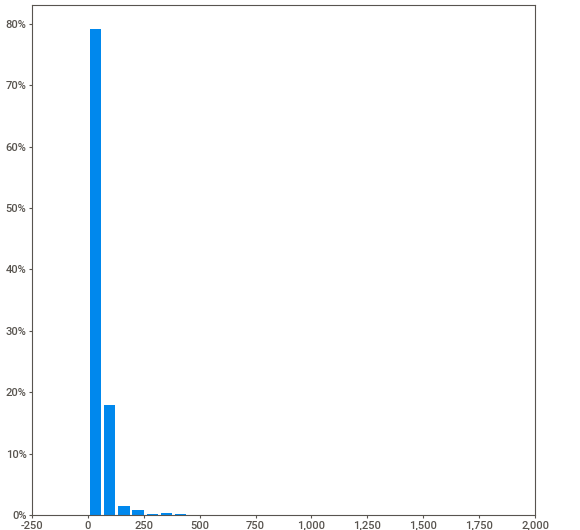
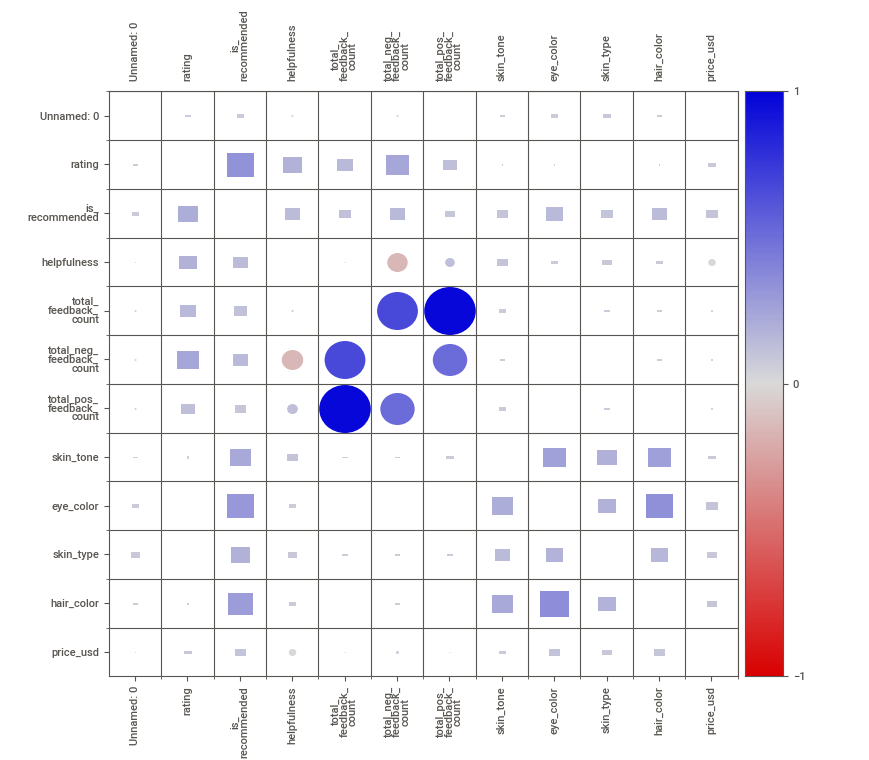
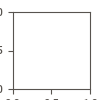

In [12]:
report.show_notebook()

<Axes: xlabel='is_recommended', ylabel='product_name'>

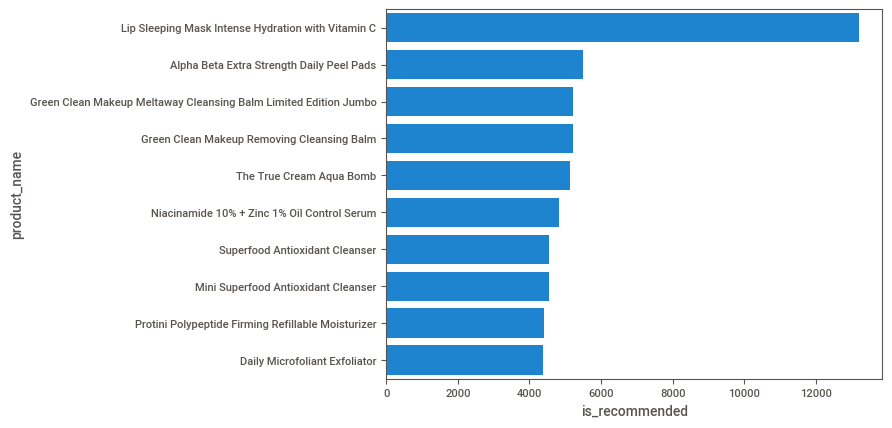

In [13]:
#Find the top 10 most reccommeded products
most_reccomended = combined_file.groupby(['product_id','product_name','brand_name']).sum(numeric_only=True)['is_recommended'].reset_index()\
.sort_values('is_recommended',ascending=False).head(10)
sns.barplot(most_reccomended,x='is_recommended',y='product_name')



In [14]:
#Get frequency of skin type
combined_file['skin_type'].value_counts()

combination    544513
dry            185937
normal         131910
oily           120494
Name: skin_type, dtype: int64

In [15]:
#Drop records with any missing values
df = combined_file.dropna(how='any')

In [16]:
#Checking rating distribution after removing NAs, we can see 5 star ratings are still significantly higher.
count = df['rating'].value_counts()
print (count)

5    175419
4     40911
1     30699
3     26050
2     21643
Name: rating, dtype: int64


In [19]:
#Using VADER to get sentiment scores for review_text
sid = SentimentIntensityAnalyzer()
df['Sentiment Scores'] = df['review_text'].apply(lambda skincare_overview: sid.polarity_scores(str(skincare_overview)))

In [20]:
df['compound'] = df['Sentiment Scores'].apply(lambda score_dict: score_dict['compound'])
df["Negative_Score"] = df['Sentiment Scores'].apply(lambda score_dict: score_dict['neg'])
df["Neutral_Score"] = df['Sentiment Scores'].apply(lambda score_dict: score_dict['neu'])
df["Positive_Score"] = df['Sentiment Scores'].apply(lambda score_dict: score_dict['pos'])



In [21]:
#Using VADER to get sentiment scores for review_title
df['Sentiment Scores 2'] = df['review_title'].apply(lambda skincare_overview2: sid.polarity_scores(str(skincare_overview2)))

df['Compound_title'] = df['Sentiment Scores 2'].apply(lambda score_dict: score_dict['compound'])
df["Negative_Score_Title"] = df['Sentiment Scores 2'].apply(lambda score_dict: score_dict['neg'])
df["Neutral_Score_Title"] = df['Sentiment Scores 2'].apply(lambda score_dict: score_dict['neu'])
df["Positive_Score_Title"] = df['Sentiment Scores 2'].apply(lambda score_dict: score_dict['pos'])




In [22]:
df = df.drop(columns=['Sentiment Scores', 'Sentiment Scores 2'], axis=1)

                                             |          | [  0%]   00:00 -> (? left)


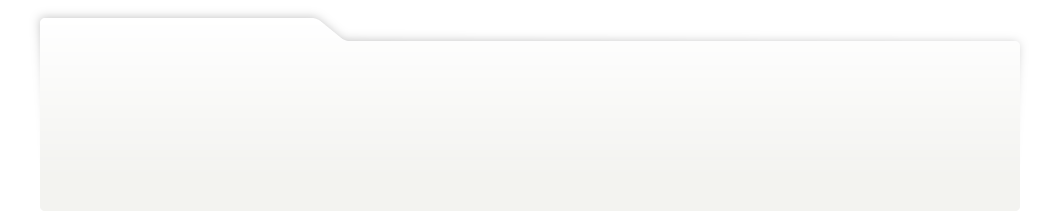
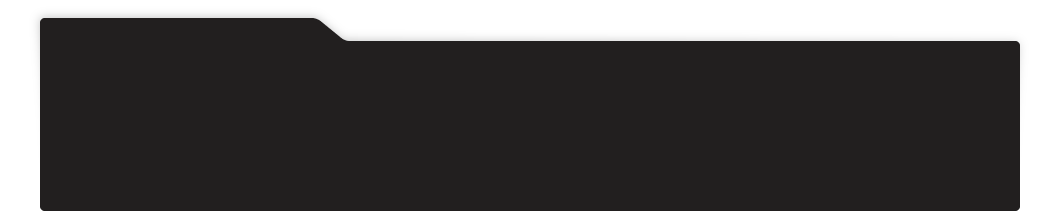
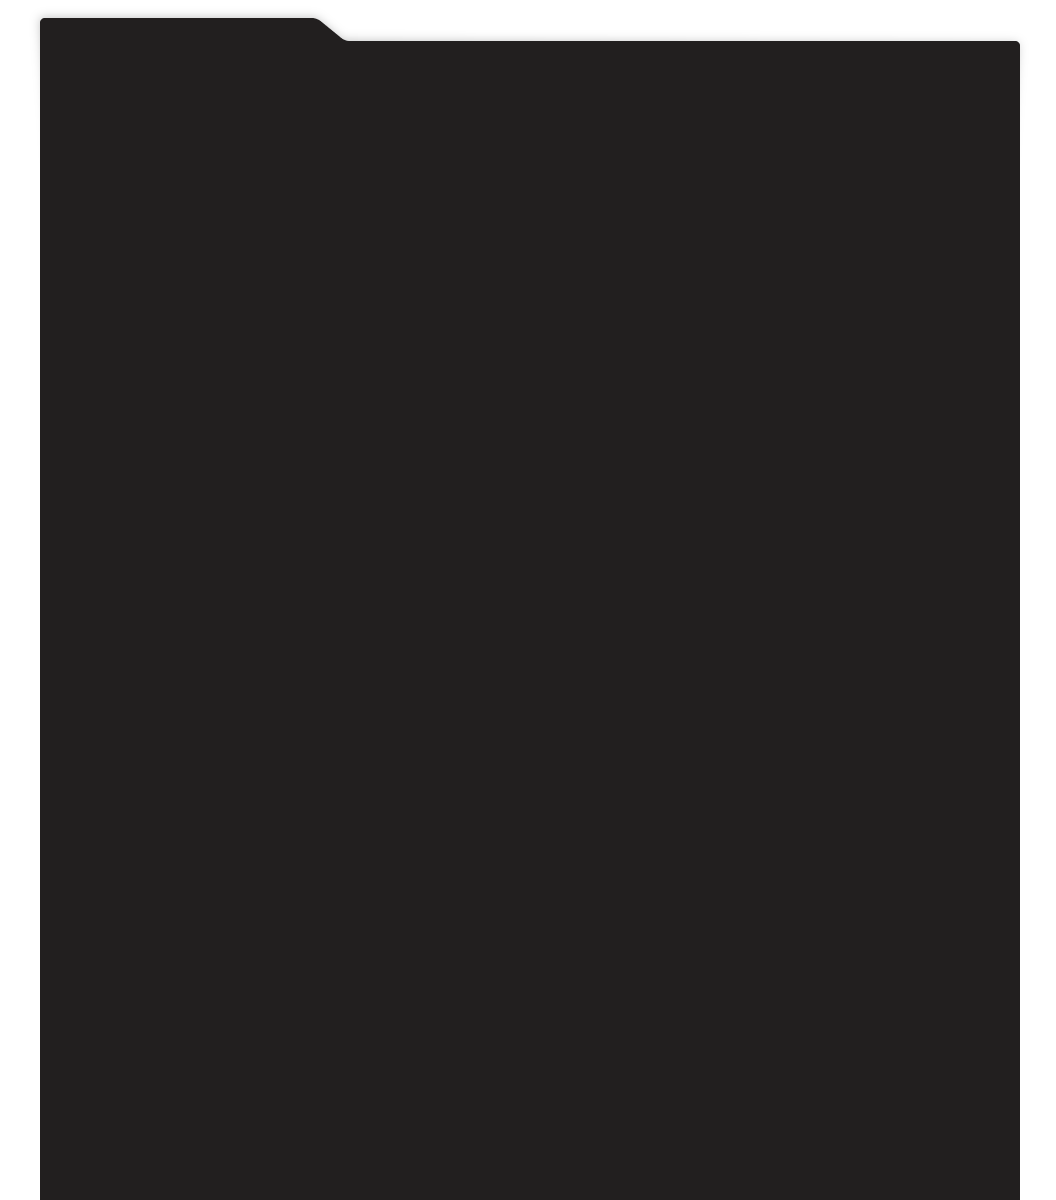
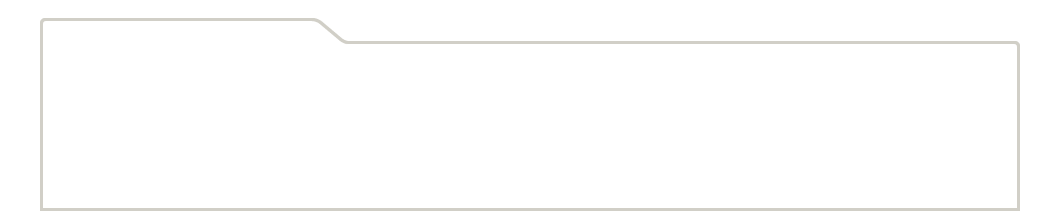
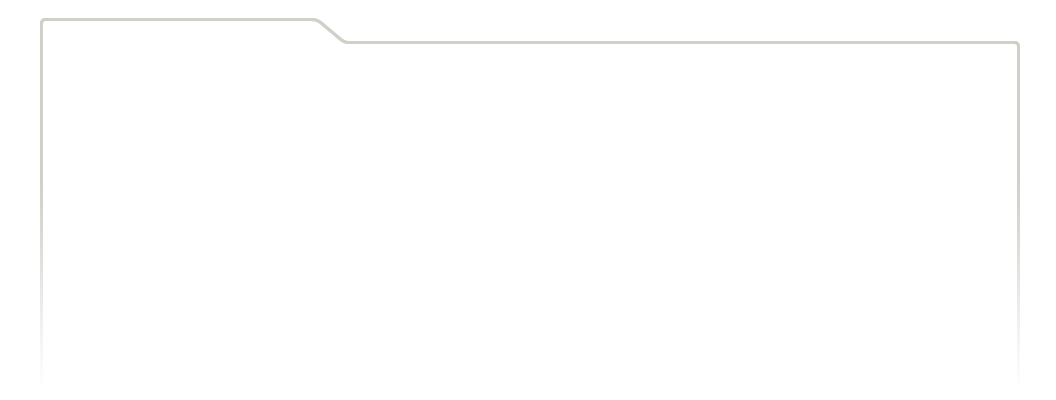
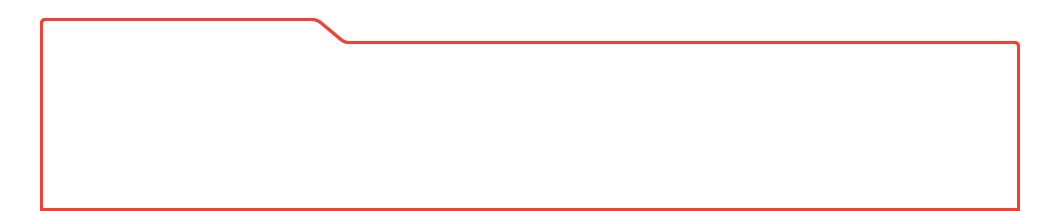
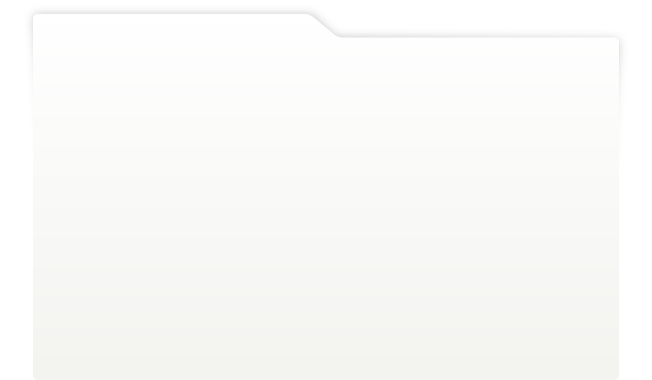
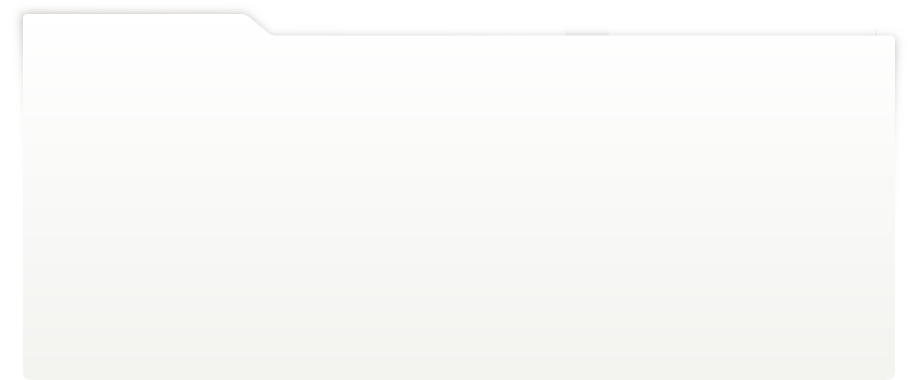
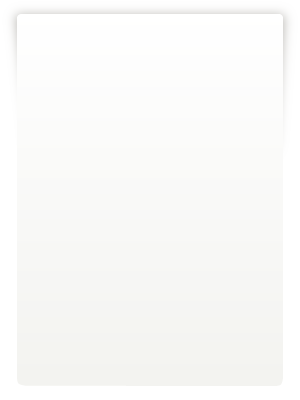
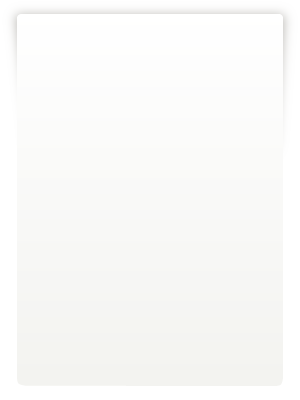
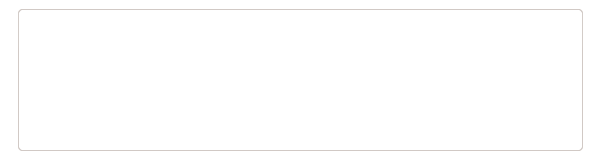
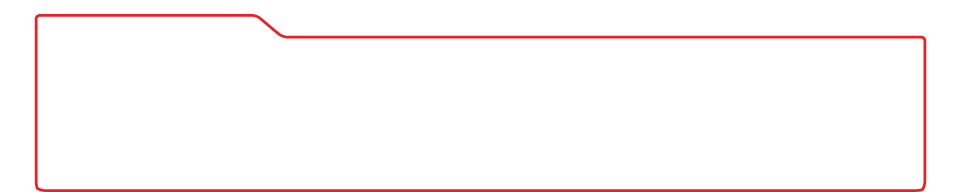
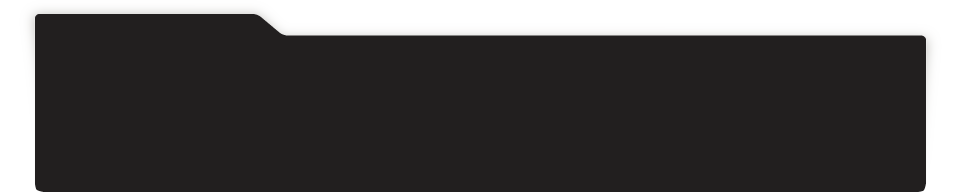
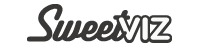
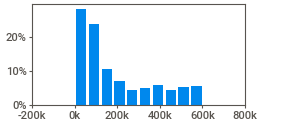
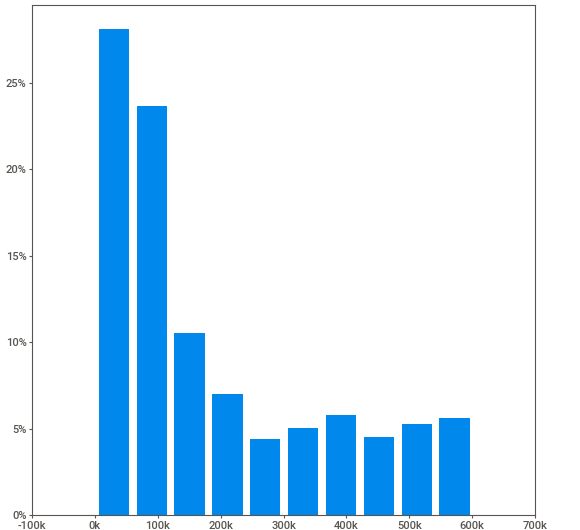
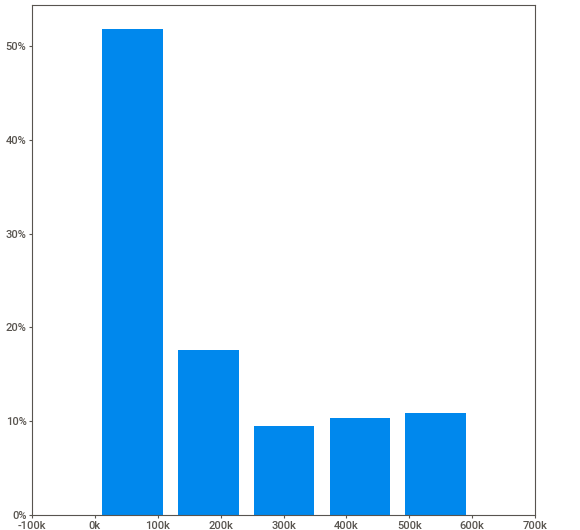
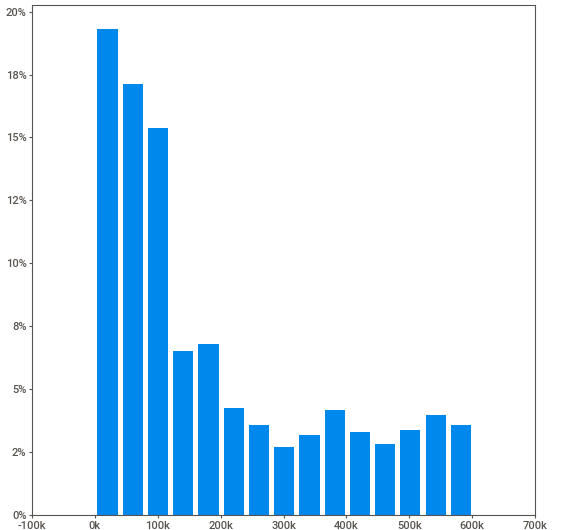
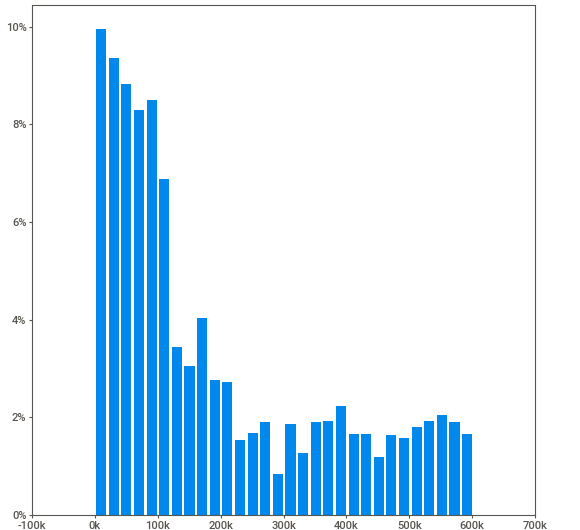
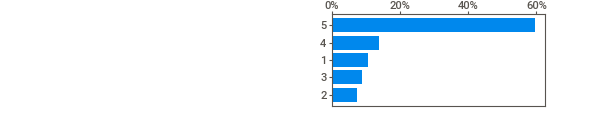
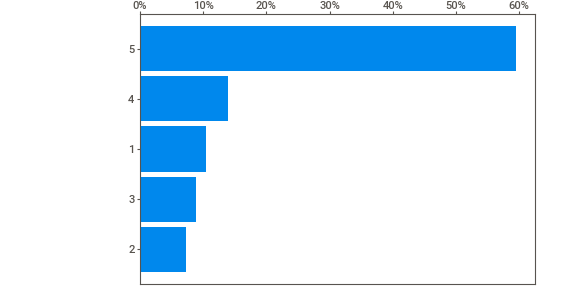
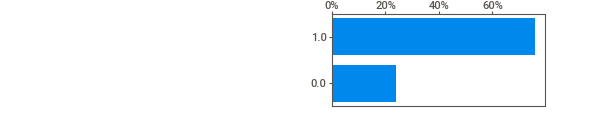
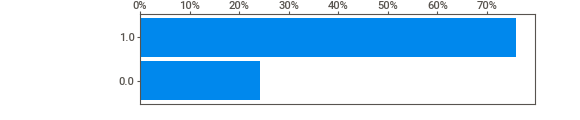
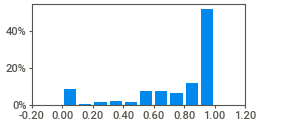
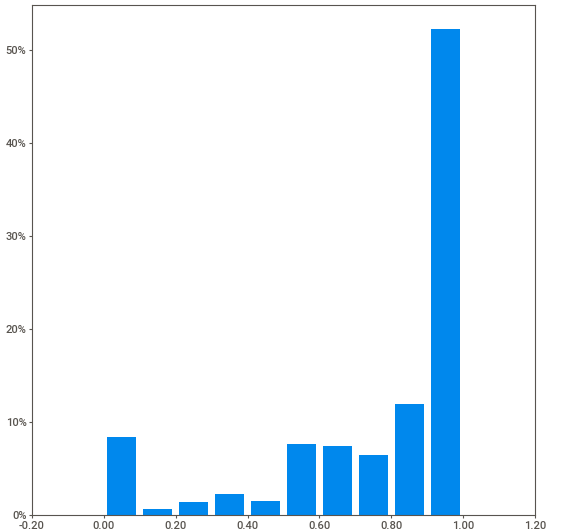
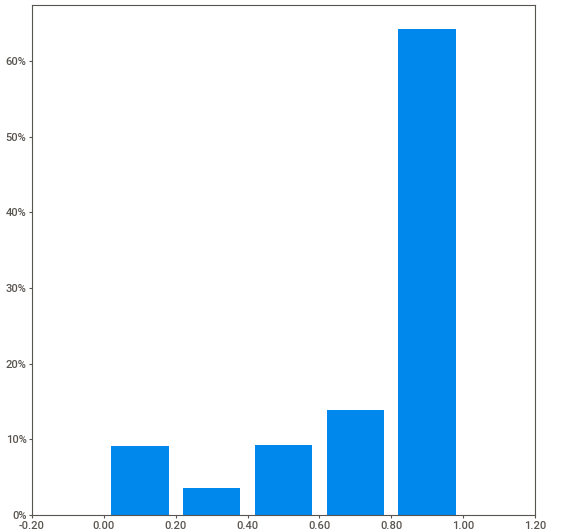
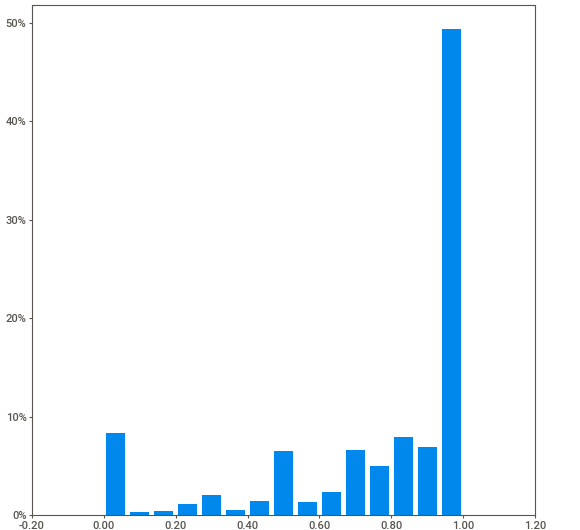
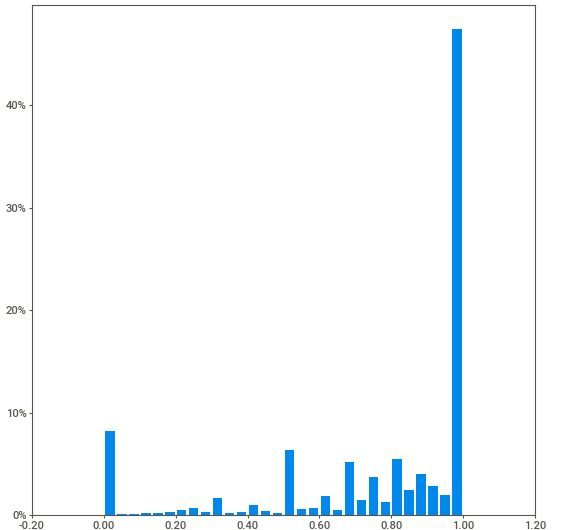
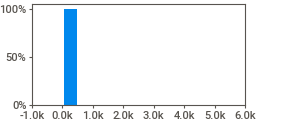
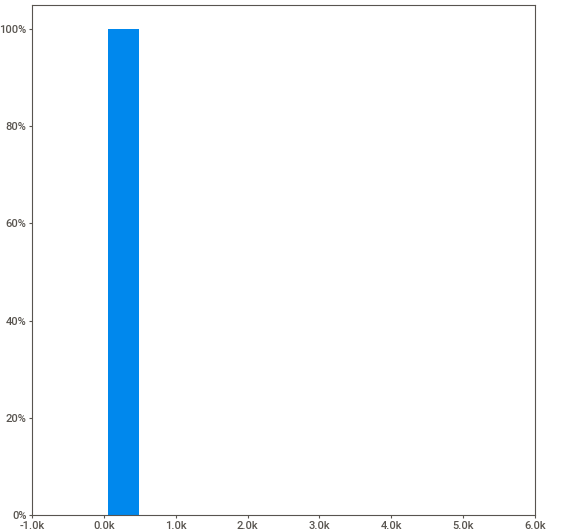
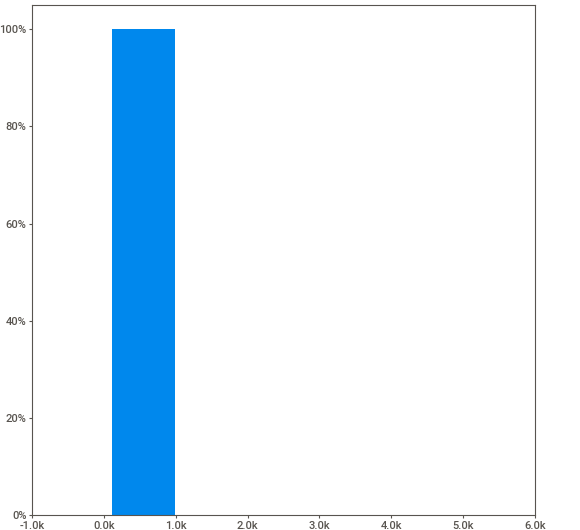
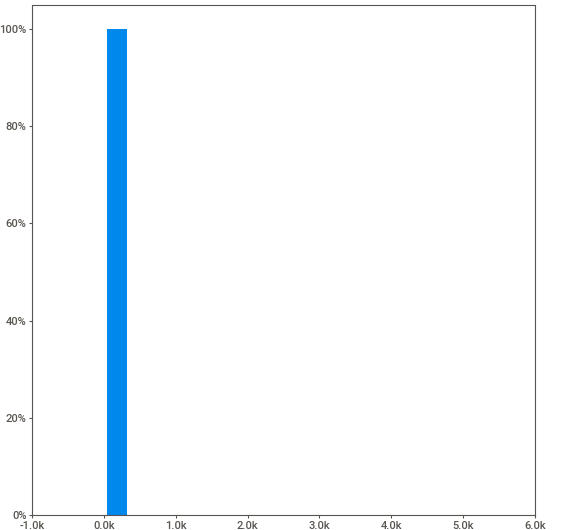
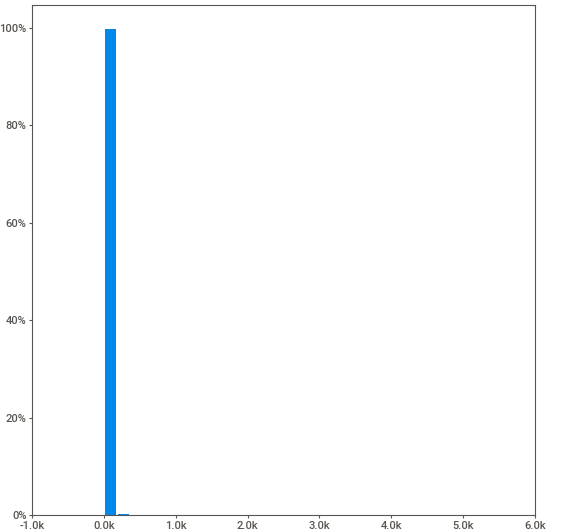
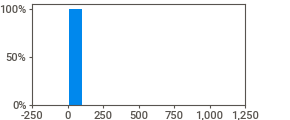
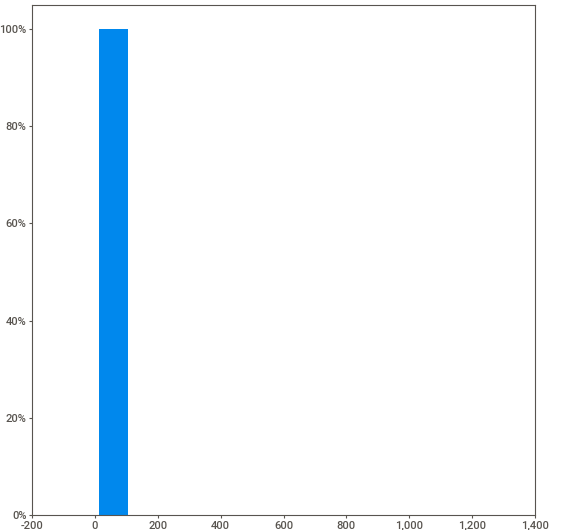
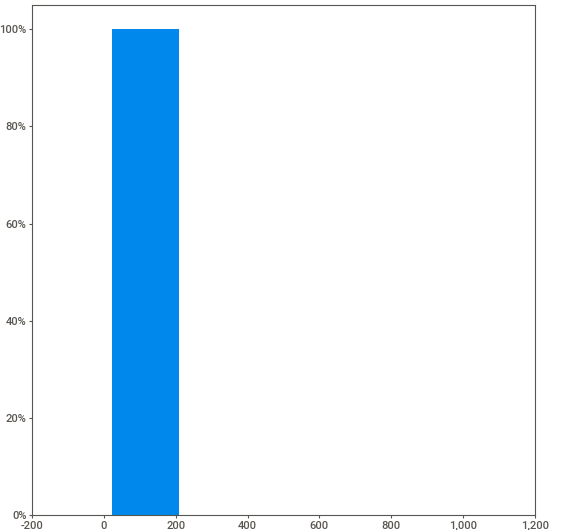
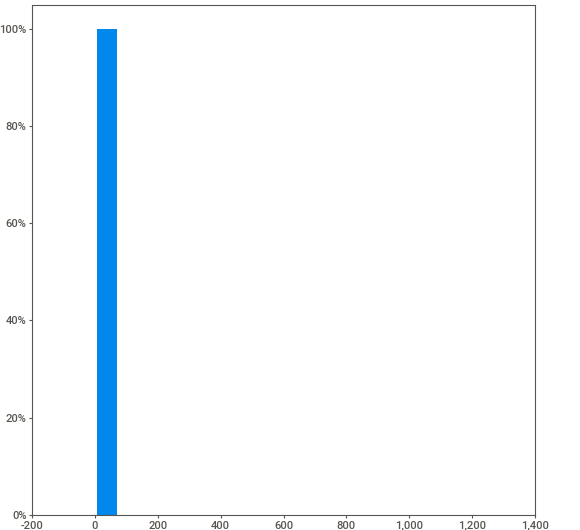
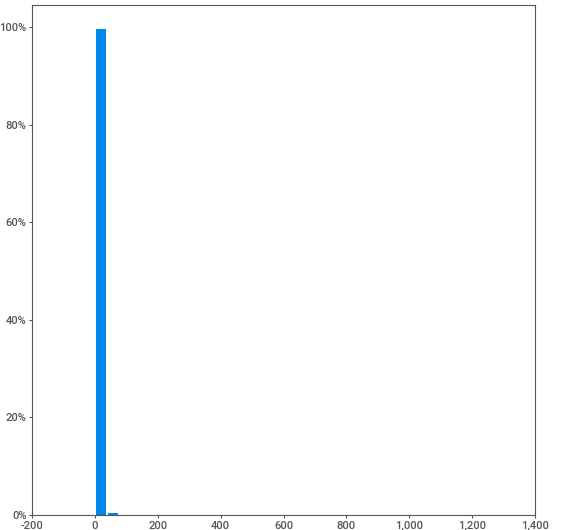
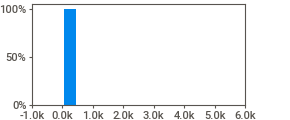
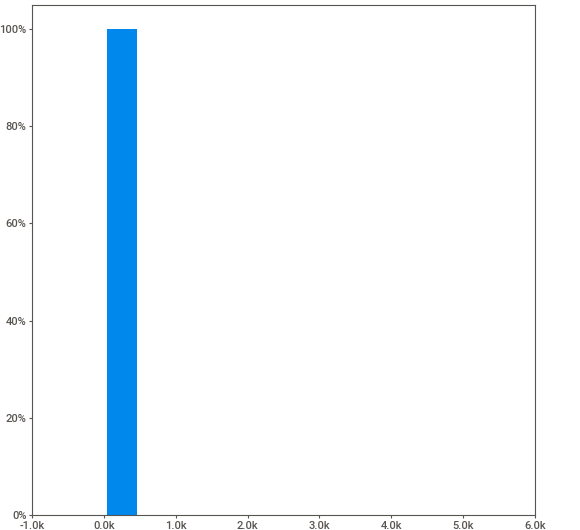
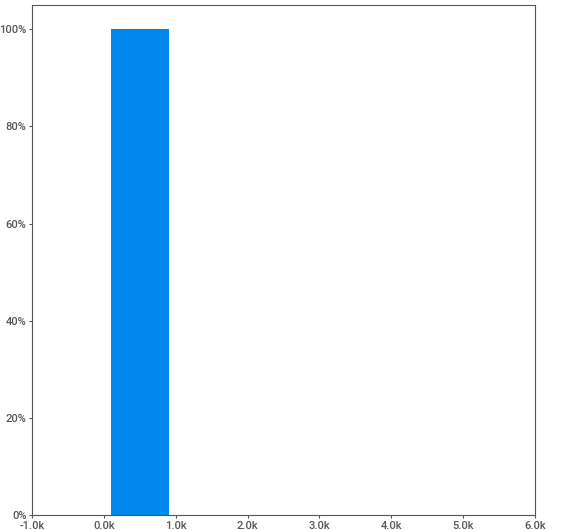
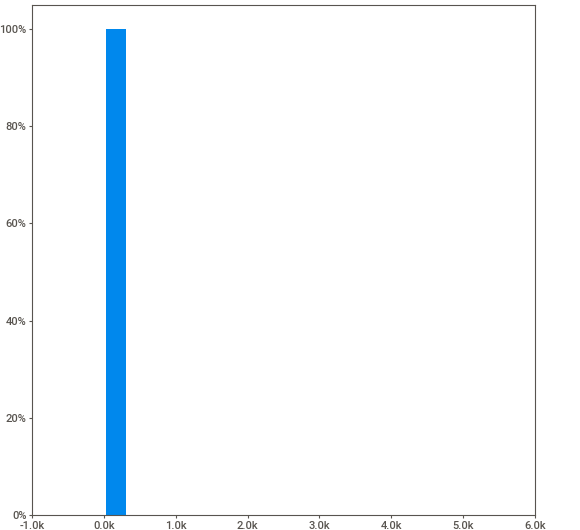
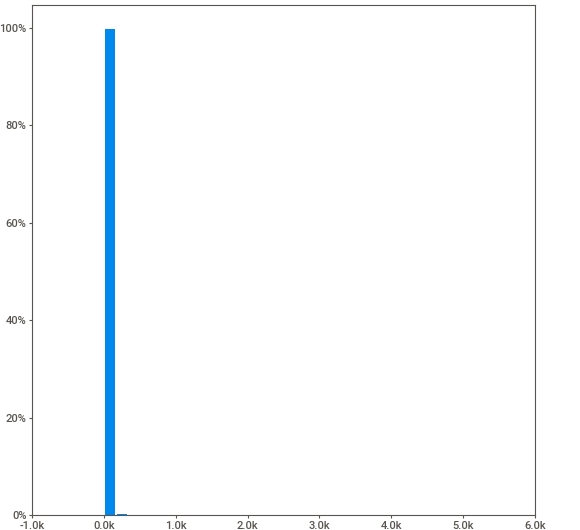
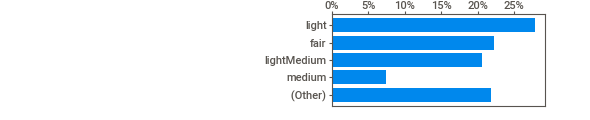
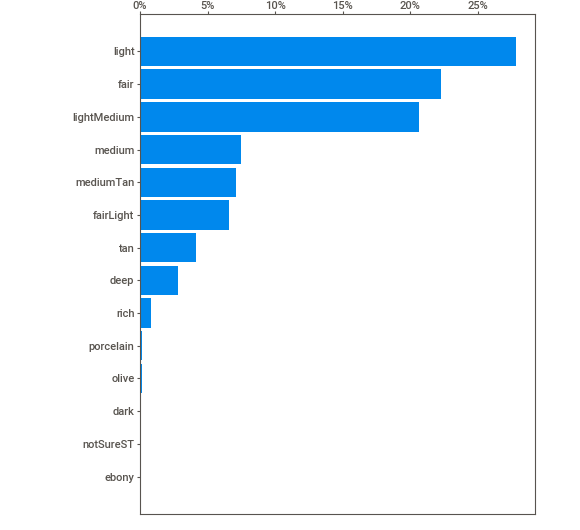
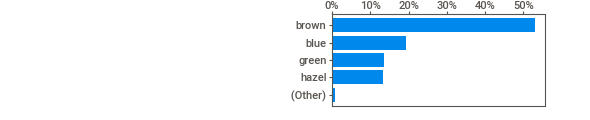
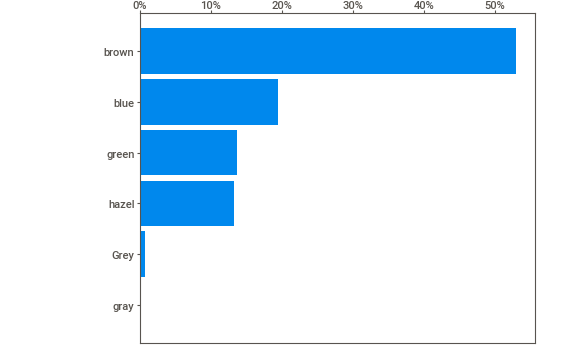
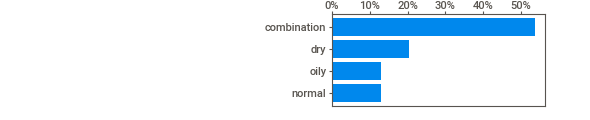
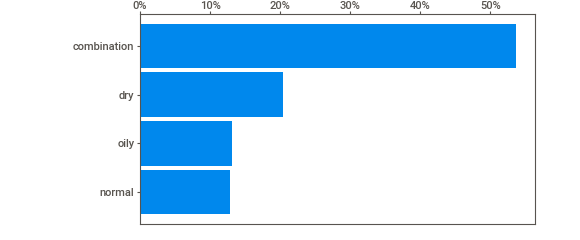
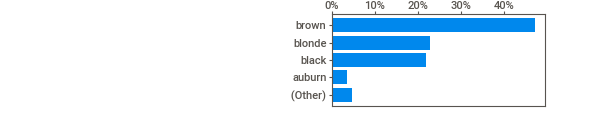
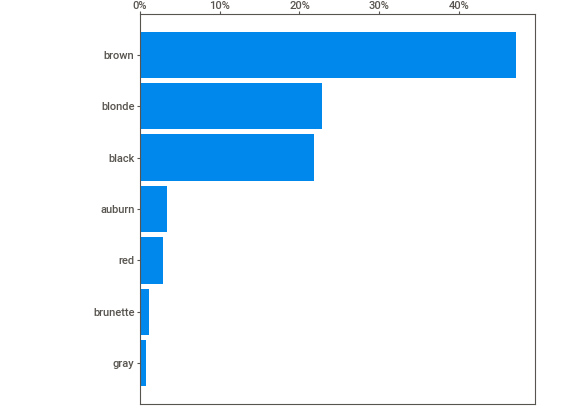
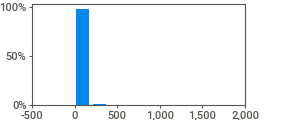
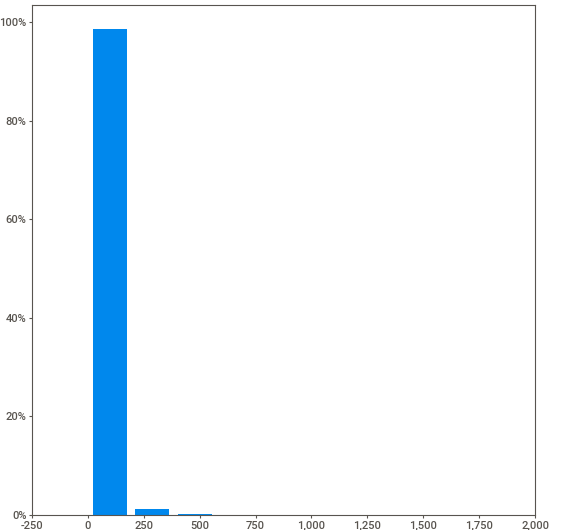
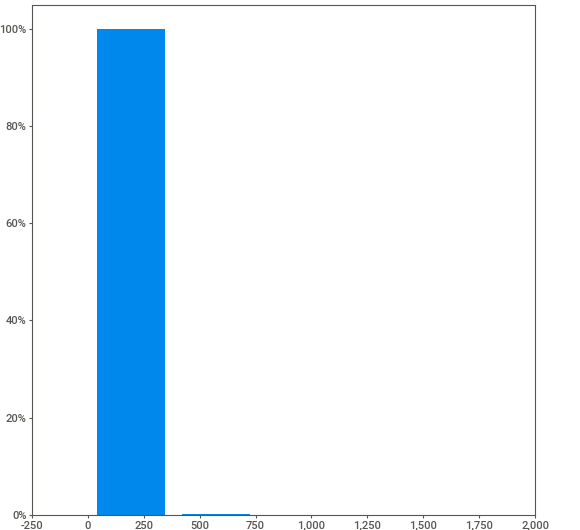
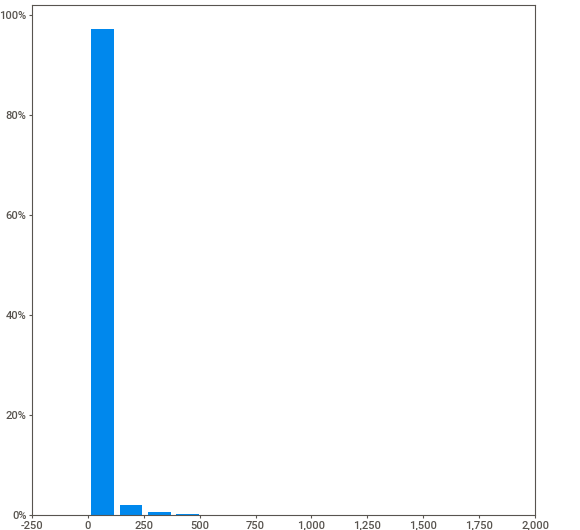
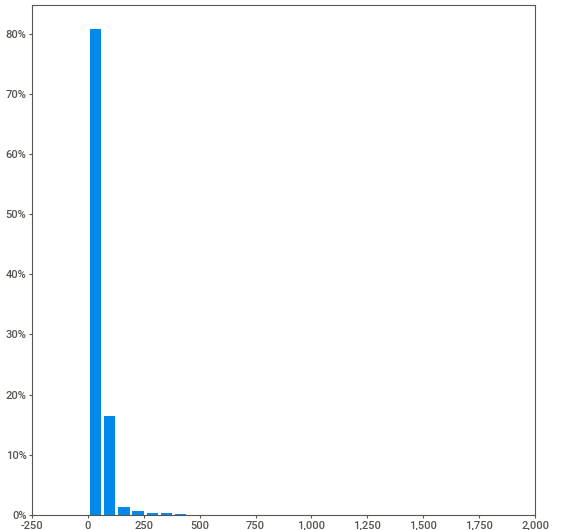
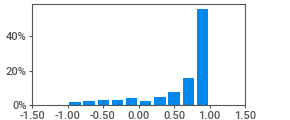
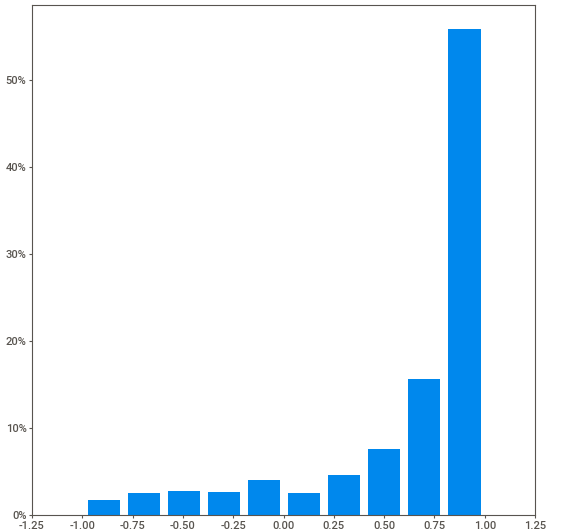
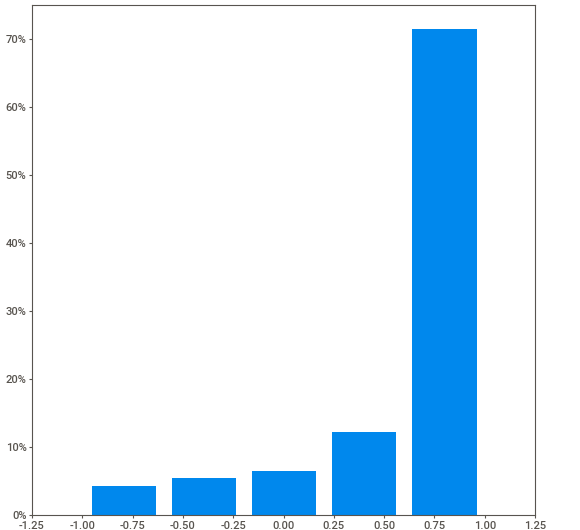
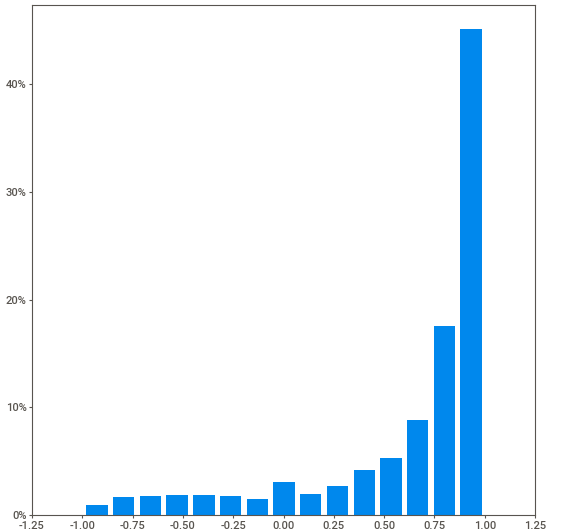
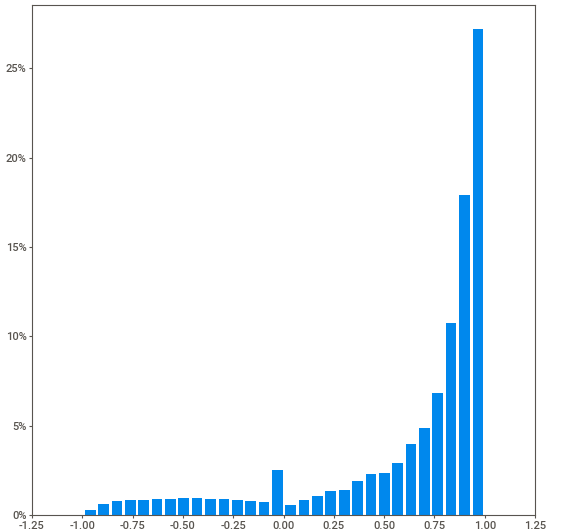
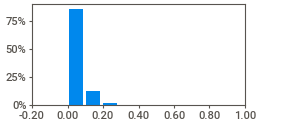
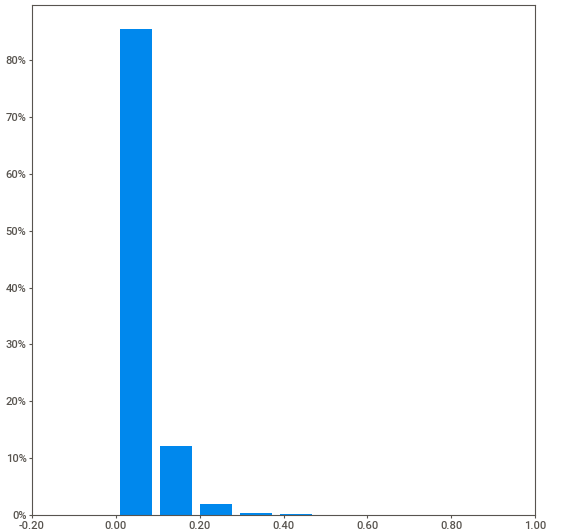
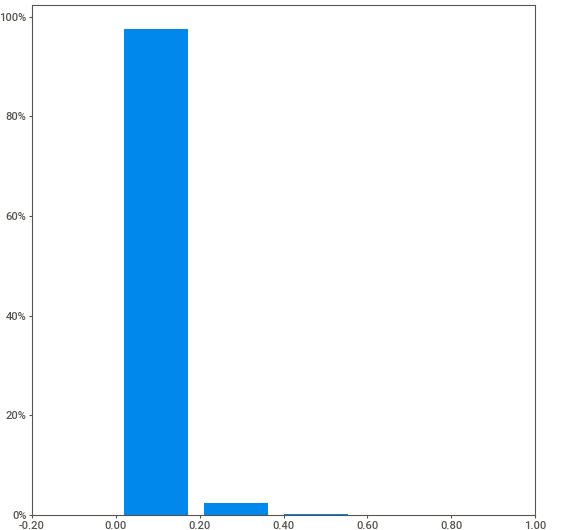
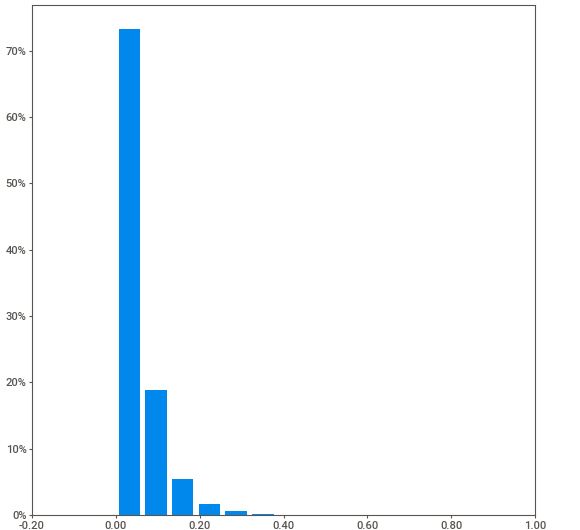
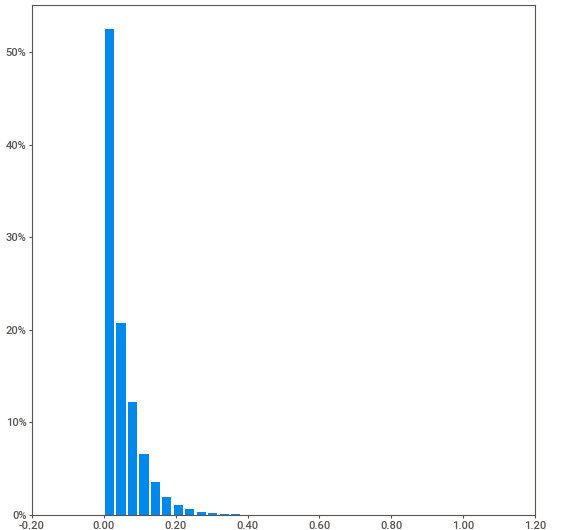
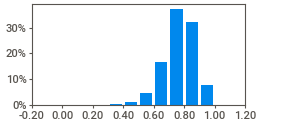
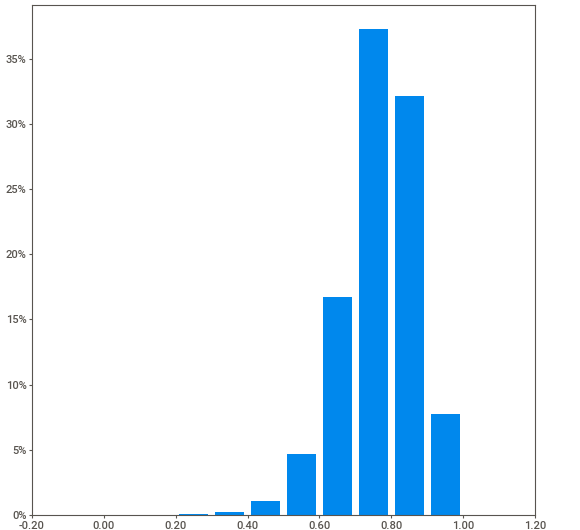
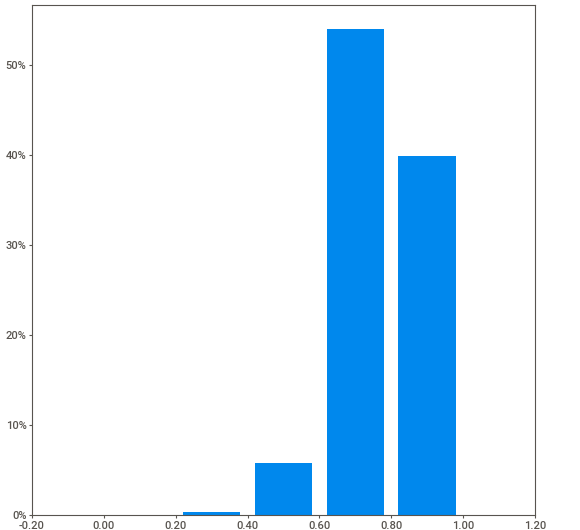
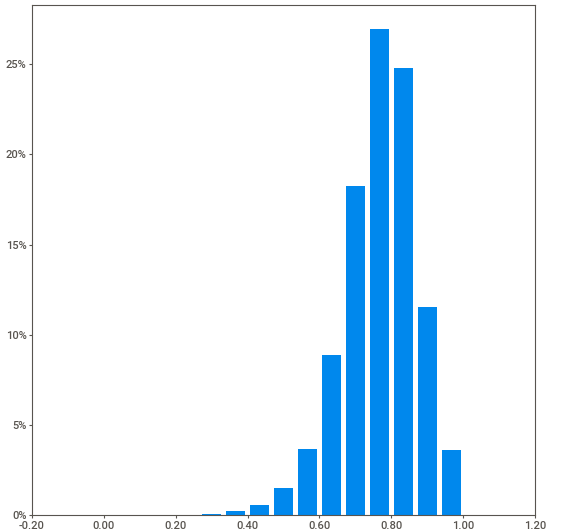
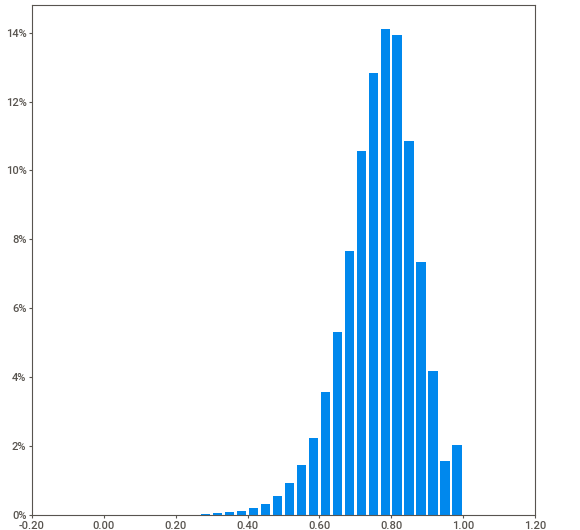
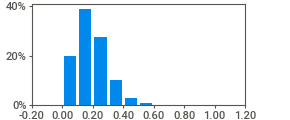
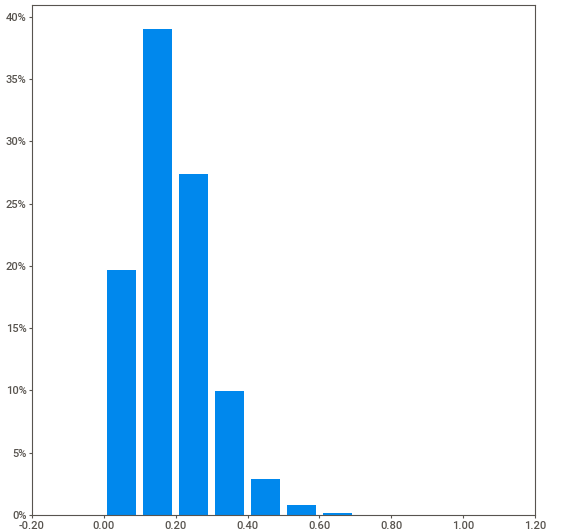
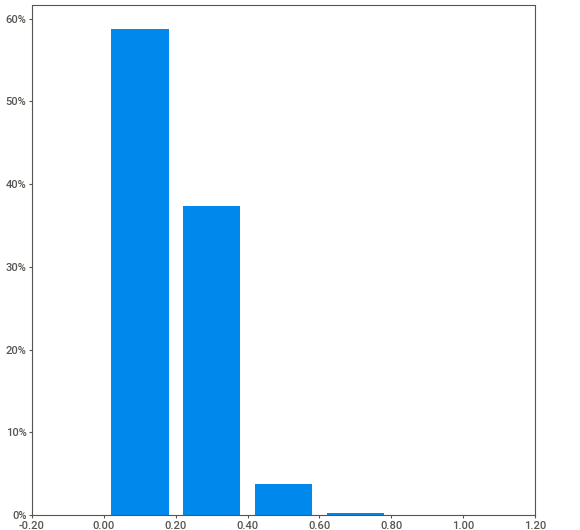
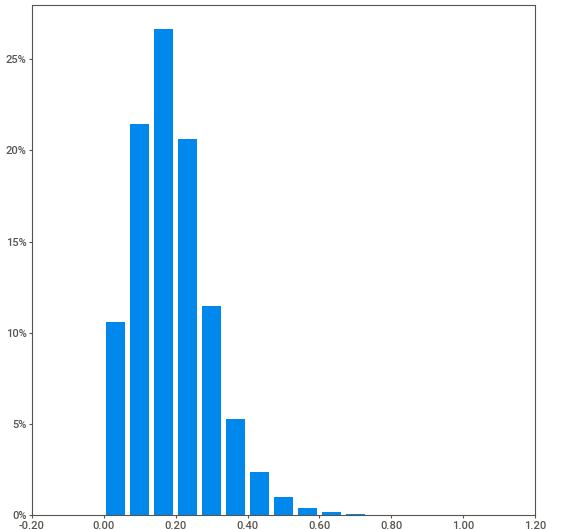
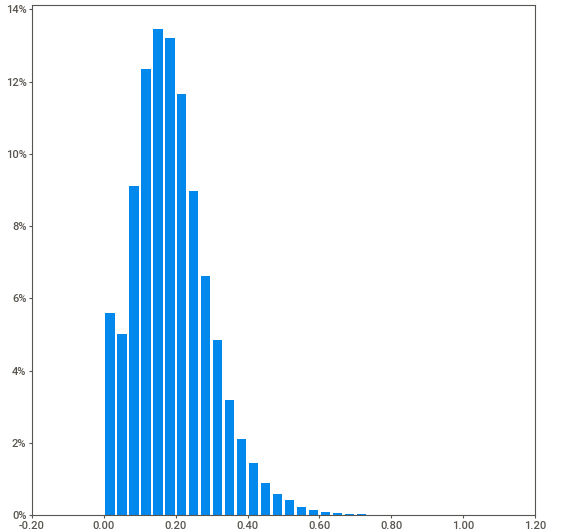
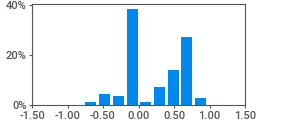
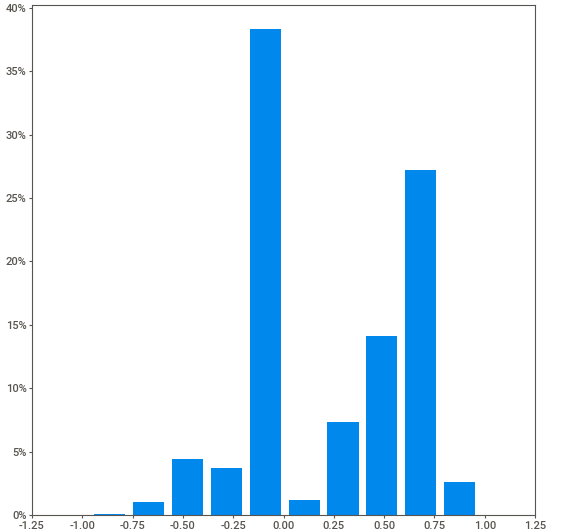
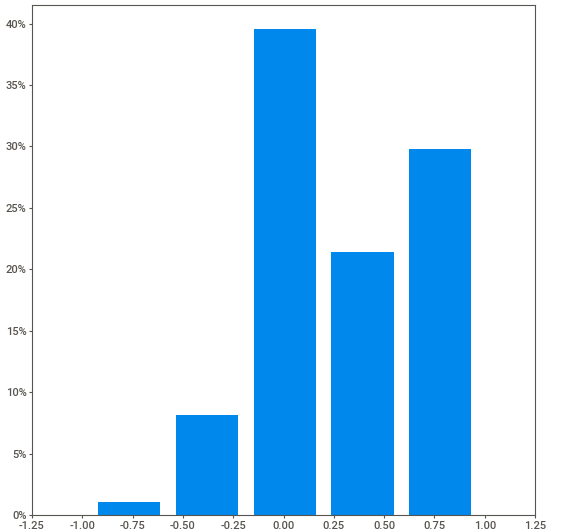
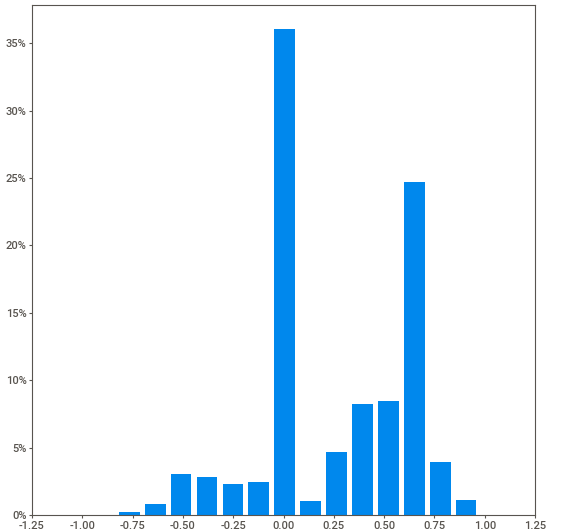
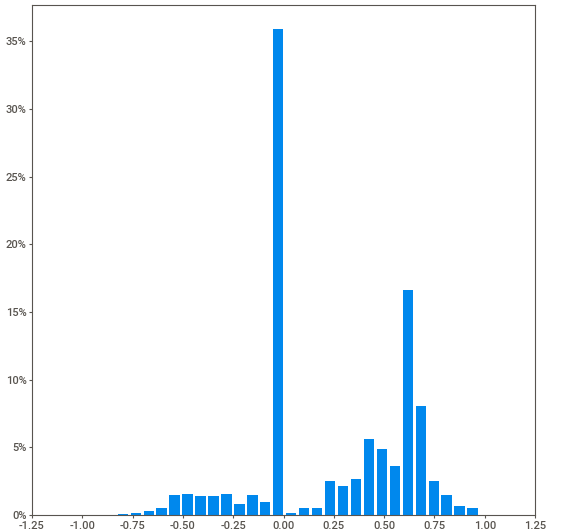
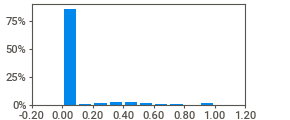
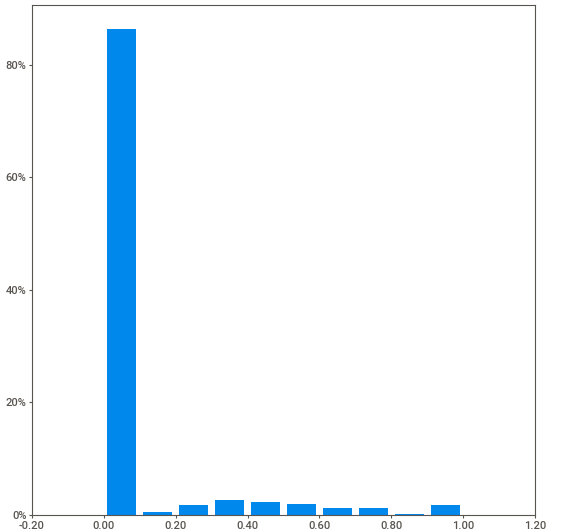
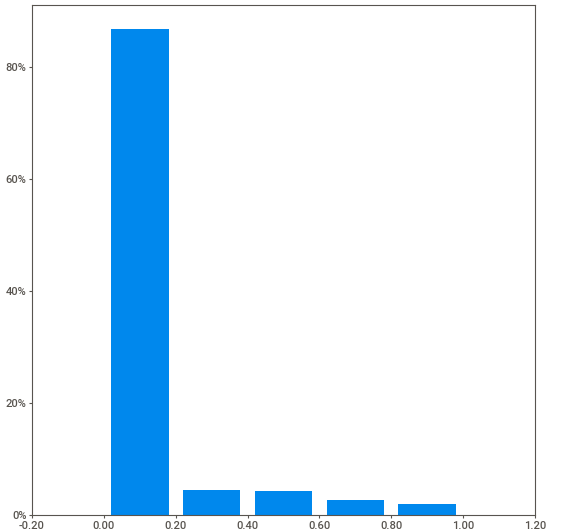
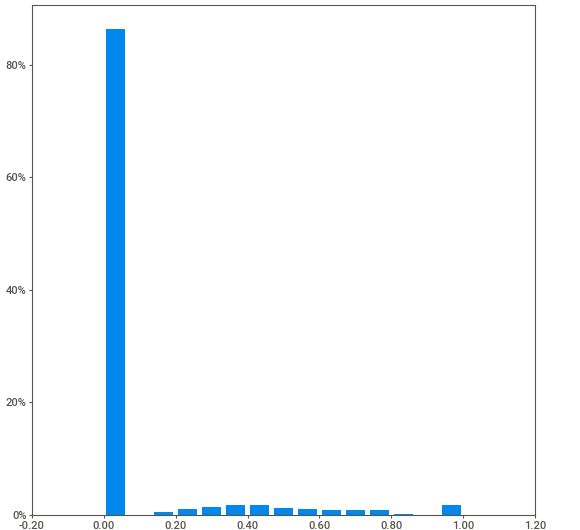
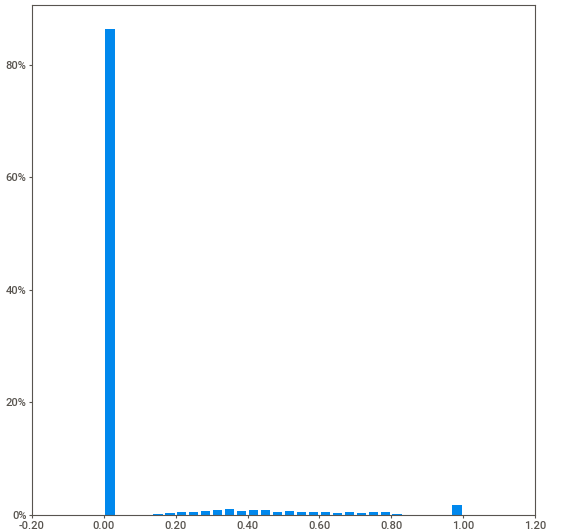
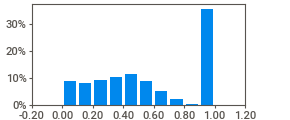
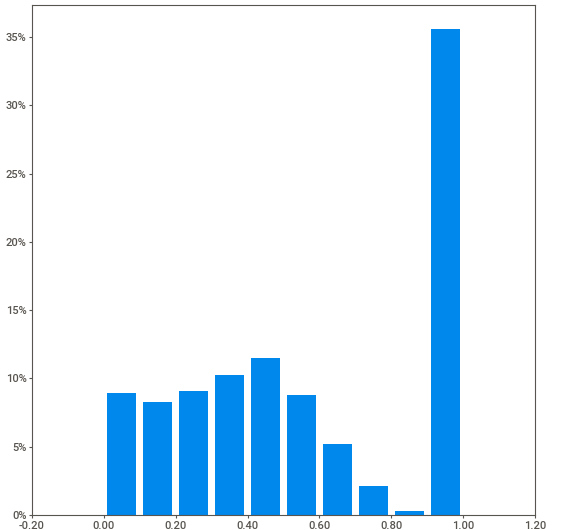
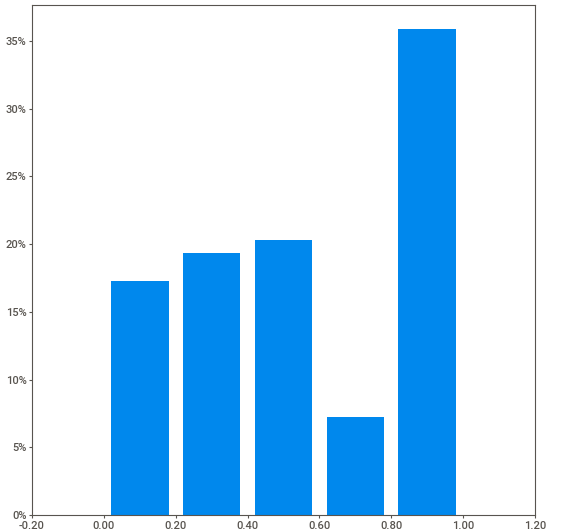
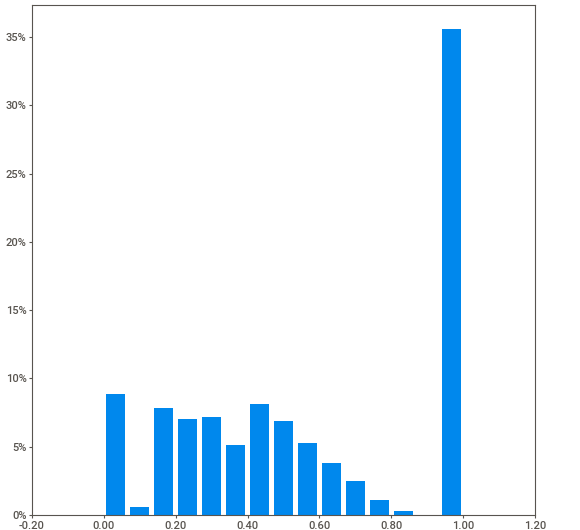
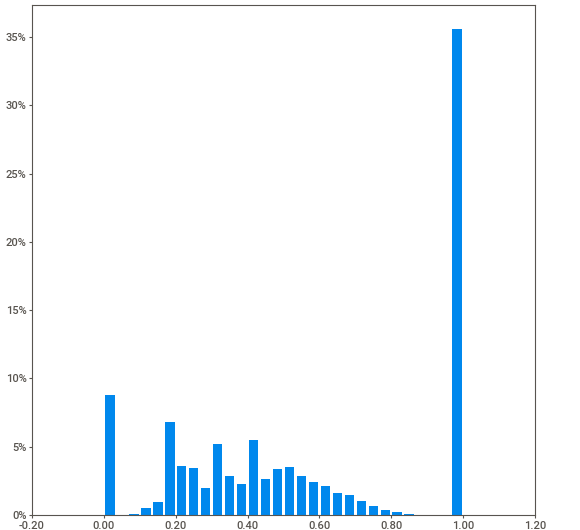
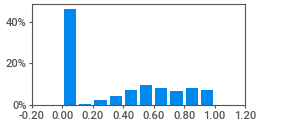
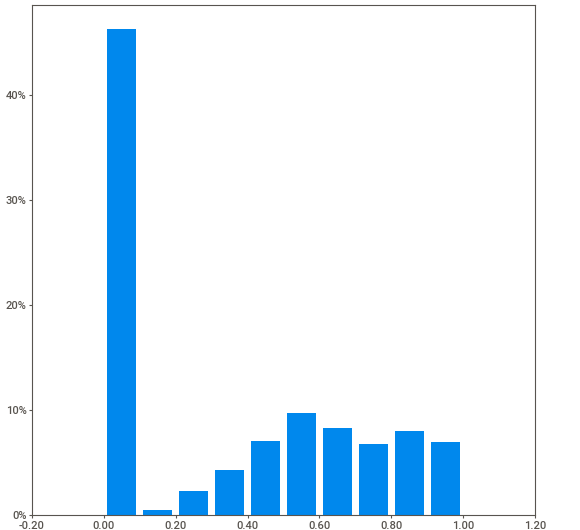
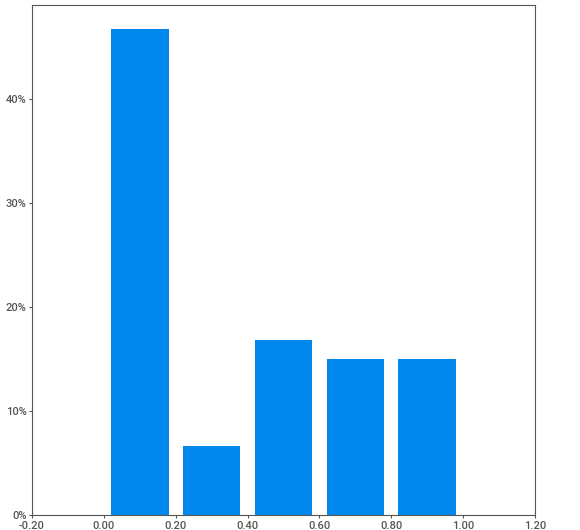
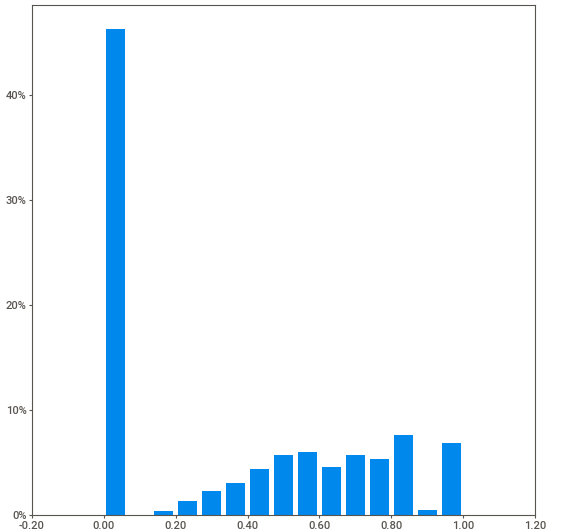
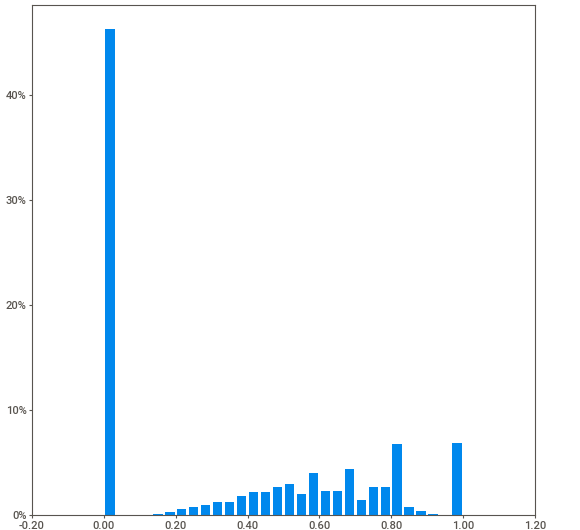
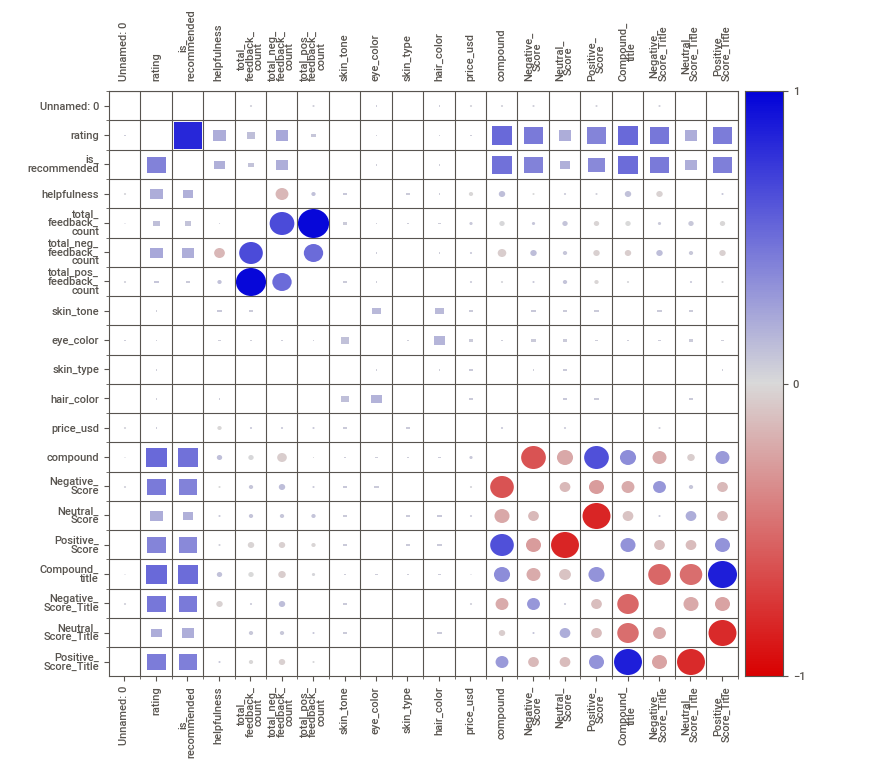
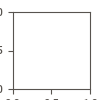

In [23]:
#Regenerate EDA report
report2 = sv.analyze(df)
report2.show_notebook()

In [24]:
df1 = df[['rating','helpfulness','total_feedback_count', 'total_neg_feedback_count','total_pos_feedback_count','price_usd','compound','Negative_Score','Neutral_Score',	'Positive_Score', 'Compound_title',	'Negative_Score_Title',	'Neutral_Score_Title',	'Positive_Score_Title']]
df1.corr(method= 'spearman')

rating  helpfulness  total_feedback_count  \
rating                    1.000000     0.216167             -0.193788   
helpfulness               0.216167     1.000000             -0.187530   
total_feedback_count     -0.193788    -0.187530              1.000000   
total_neg_feedback_count -0.281798    -0.860280              0.544273   
total_pos_feedback_count -0.111928     0.121564              0.926819   
price_usd                 0.010186    -0.051438             -0.015722   
compound                  0.391284     0.097610             -0.122540   
Negative_Score           -0.321957    -0.054664              0.171206   
Neutral_Score            -0.160531    -0.009244              0.144512   
Positive_Score            0.358016     0.059050             -0.223058   
Compound_title            0.437390     0.109545             -0.158596   
Negative_Score_Title     -0.397450    -0.107060              0.128399   
Neutral_Score_Title      -0.151751    -0.018177              0.101596   
Positive_Score_Title      0.356096     0.080331             -0.161447   

                          total_neg_feedback_count  total_pos_feedback_count  \
rating                                   -0.281798                 -0.111928   
helpfulness                              -0.860280                  0.121564   
total_feedback_count                      0.544273                  0.926819   
total_neg_feedback_count                  1.000000                  0.273059   
total_pos_feedback_count                  0.273059                  1.000000   
price_usd                                 0.044530                 -0.024389   
compound                                 -0.139493                 -0.081684   
Negative_Score                            0.122994                  0.149175   
Neutral_Score                             0.067580                  0.143234   
Positive_Score                           -0.146512                 -0.200781   
Compound_title                           -0.167265                 -0.115730   
Negative_Score_Title                      0.151374                  0.085024   
Neutral_Score_Title                       0.060646                  0.096302   
Positive_Score_Title                     -0.142087                 -0.130529   

                          price_usd  compound  Negative_Score  Neutral_Score  \
rating                     0.010186  0.391284       -0.321957      -0.160531   
helpfulness               -0.051438  0.097610       -0.054664      -0.009244   
total_feedback_count      -0.015722 -0.122540        0.171206       0.144512   
total_neg_feedback_count   0.044530 -0.139493        0.122994       0.067580   
total_pos_feedback_count  -0.024389 -0.081684        0.149175       0.143234   
price_usd                  1.000000  0.076603       -0.012327       0.009600   
compound                   0.076603  1.000000       -0.408278      -0.413297   
Negative_Score            -0.012327 -0.408278        1.000000      -0.129995   
Neutral_Score              0.009600 -0.413297       -0.129995       1.000000   
Positive_Score             0.008271  0.694541       -0.347224      -0.832463   
Compound_title            -0.002094  0.290250       -0.222283      -0.157890   
Negative_Score_Title      -0.001414 -0.220854        0.241560       0.043562   
Neutral_Score_Title        0.005056 -0.107847        0.067310       0.171452   
Positive_Score_Title      -0.001252  0.233630       -0.189162      -0.184331   

                          Positive_Score  Compound_title  \
rating                          0.358016        0.437390   
helpfulness                     0.059050        0.109545   
total_feedback_count           -0.223058       -0.158596   
total_neg_feedback_count       -0.146512       -0.167265   
total_pos_feedback_count       -0.200781       -0.115730   
price_usd                       0.008271       -0.002094   
compound                        0.694541        0.290250   
Negative_Score                 -0.347224       -0.

In [26]:
import scipy.stats as ss
def cramers_corrected_stat(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
cramers_corrected_stat(pd.crosstab(df['rating'],df['is_recommended']))

0.9185314908735425